# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')

print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")


Last modified: 22 December 2025, 22:03 IST


# Imports 

In [2]:
import os
import sys
import time
import gc
import psutil
import json

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
# import mplhep as hep

# Numerical computing
import vector
import hist
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
import dask.bag as db
import dask_awkward as dak
from dask.diagnostics import ProgressBar

# others
!pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

 All imports loaded


In [3]:
print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")

awkward: 2.8.5
dask-awkward: 2025.5.0


In [5]:
# from dask.distributed import get_client

# try:
#     client = get_client()  # Gets existing client if any
#     print(f"Found existing client: {client.dashboard_link}")
# except ValueError:
#     print("No existing client found")
#     # Create your own
#     client = Client("tls://localhost:8786")

# JSON validation functions

In [6]:
RUN_PERIODS_2016 = {
    'Run2016G': {'run_min': 278820, 'run_max': 280385},
    'Run2016H': {'run_min': 280919, 'run_max': 284044}
}

def load_golden_json(json_path):
    """Load and parse golden JSON file for data certification"""
    with open(json_path, 'r') as f:
        golden_json = json.load(f)
    
    
    valid_lumis = {}
    for run, lumi_ranges in golden_json.items():
        valid_lumis[int(run)] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis

def apply_json_mask(arrays, json_path, run_periods=None):

    valid_lumis = load_golden_json(json_path)
    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    
    mask = np.zeros(len(runs), dtype=bool)
    
    unique_runs = np.unique(runs)
    
    for run in unique_runs:
        run_int = int(run)
        
      
        if run_int not in valid_lumis:
            continue
        
        
        if run_periods is not None:
            run_in_allowed_period = False
            
            
            for period_name, period_info in run_periods.items():
                run_min = period_info['run_min']
                run_max = period_info['run_max']
                
                if run_min <= run_int <= run_max:
                    run_in_allowed_period = True
                    break  
            
           
            if not run_in_allowed_period:
                continue
        
       
        run_mask = (runs == run)
        run_lumis = lumis[run_mask]
        
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        for lumi_start, lumi_end in valid_lumis[run_int]:
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

# Setting up directory and files

In [58]:

print(f"Server: {os.uname().nodename}")
# Parallel processing
N_WORKERS = 20     

XROOTD_TIMEOUT = 600  # 10 minutes read timeout
XROOTD_MAX_RETRIES = 3  # Retry failed files 3 times
XROOTD_RETRY_WAIT = 10  # Wait 10 seconds between retries

print(f"Using {N_WORKERS} parallel workers")
print(f"XRootD timeout: {XROOTD_TIMEOUT}s ({XROOTD_TIMEOUT/60:.1f} min)")
print(f"Max retries: {XROOTD_MAX_RETRIES}")

# File paths
BASE_PATH = "/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets"
DATA_DIR = os.path.join(BASE_PATH, "DATA")
MC_DIR = os.path.join(BASE_PATH, "MC_samples")

# LOAD FILE URLS

def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    
    mapping = {
        # Data 
        'data': 'Data'  ,   
        # ,
        # # MC samples
        'higgs': 'signal',
        'dytoll': 'DY_to_Tau_Tau',          # DYtoLL.txt
        'top': 'Top_antitop',            # Top.txt
        'fakes': 'Fakes',                # Fakes.txt
        'vz': 'Diboson',                 # VZ.txt(Diboson)
        'ggww': 'ggWW',                  # ggWW.txt
        'ww': 'WW',                      # WW.txt 
        'vg': 'VG'                       # VG.txt
    }
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
            
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
                
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            
            # Find label
            label = None
            for pattern, sample_label in mapping.items():
                if pattern in filename_lower:
                    label = sample_label
                    break
            
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict
    

files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=5)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)

##----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Golden JSON path for data validation
JSON_2016 = "/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"

print("\n" + "="*70)
print("DATA VALIDATION - GOLDEN JSON")
print("="*70)
print(f"Golden JSON: {JSON_2016}")
print(f"File exists: {os.path.exists(JSON_2016)}")

if os.path.exists(JSON_2016):
    with open(JSON_2016, 'r') as f:
        golden_json = json.load(f)
    
    n_runs_total = len(golden_json)
    total_lumis_all = sum(len(ranges) for ranges in golden_json.values())
    all_runs = sorted([int(run) for run in golden_json.keys()])
    
    print(f"\nGolden JSON File Statistics:")
    print(f"  Total runs       : {n_runs_total}")
    print(f"  Total lumi sections: {total_lumis_all}")
    print(f"  Run range        : {min(all_runs)} - {max(all_runs)}")
    
    
    print("\n" + "-"*70)
    print("ANALYSIS WILL USE: Run2016G + Run2016H ONLY")
    print("-"*70)
    
    total_used_runs = 0
    total_used_lumis = 0
    
    for period_name, period_info in RUN_PERIODS_2016.items():
        run_min = period_info['run_min']
        run_max = period_info['run_max']
        
        
        period_runs = [r for r in all_runs if run_min <= r <= run_max]
        period_lumis = sum(len(golden_json[str(r)]) for r in period_runs)
        
        total_used_runs += len(period_runs)
        total_used_lumis += period_lumis
        
        print(f"\n{period_name}:")
        print(f"  Run range        : {run_min} - {run_max}")
        print(f"  Certified runs   : {len(period_runs)}")
        print(f"  Lumi sections    : {period_lumis}")
        if len(period_runs) > 0:
            print(f"  Actual range     : {min(period_runs)} - {max(period_runs)}")
        else:
            print(f"  WARNING: No certified runs found!")
    
    # Summary
    runs_excluded = n_runs_total - total_used_runs
    lumis_excluded = total_lumis_all - total_used_lumis
    
    print("\n" + "-"*70)
    print("SUMMARY:")
    print(f"  Will use       : {total_used_runs} runs, {total_used_lumis} lumi sections")
    print(f"  Will exclude   : {runs_excluded} runs, {lumis_excluded} lumi sections")
    print(f"                     (outside Run2016G/H ranges)")
    print("-"*70)
    
else:
    print("WARNING: Golden JSON file not found!")
    
print("="*70)


Server: jupyter-anujraghav-2ephysics-40gmail-2ecom
Using 20 parallel workers
XRootD timeout: 600s (10.0 min)
Max retries: 3

FILES TO PROCESS
Data                :    5 files
VG                  :    5 files
signal              :    5 files
WW                  :    5 files
Fakes               :    5 files
Diboson             :    5 files
DY_to_Tau_Tau       :    5 files
ggWW                :    5 files
Top_antitop         :    5 files
______________________________________________________________________
TOTAL               :   45 files

DATA VALIDATION - GOLDEN JSON
Golden JSON: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
File exists: True

Golden JSON File Statistics:
  Total runs       : 393
  Total lumi sections: 523
  Run range        : 273158 - 284044

----------------------------------------------------------------------
ANALYSIS WILL USE: Run2016G + Run2016H ONLY
--------------------------------------------

## Samples Dictionary

In [59]:
SAMPLES = {
    "signal": {
        "color": "#E41A1C",  
        "is_signal": True,
        "stack_order": None
    },
    "DY_to_Tau_Tau": {
        "color": "#33A02C",  
        "is_signal": False,
        "stack_order": 1  # 62M events - 2nd largest
    },
    "Diboson": {
        "color": "#A6CEE3",  
        "is_signal": False,
        "stack_order": 4  # 265k events
    },
    "VG": {
        "color": "#FFCC00", 
        "is_signal": False,
        "stack_order": 2  # 4.6M events - 3rd largest
    },
    "WW": {
        "color": "#1F78B4",  
        "is_signal": False,
        "stack_order": 5  # 121k events
    },
    "Top_antitop": {
        "color": "#FF7F00",  
        "is_signal": False,
        "stack_order": 3  # 2.3M events - 4th largest
    },
    "ggWW": {
        "color": "#6BAED6",  
        "is_signal": False,
        "stack_order": 6  # 57k events - SMALLEST (top of stack)
    },
    "Fakes": {
        "color": "#B3B3B3",  
        "is_signal": False,
        "stack_order": 0  # 635M events - LARGEST (bottom of stack)
    },
    "Data": {
        "color": "#000000",  
        "is_signal": False,
        "stack_order": None
    }
}

colors = {key: value["color"] for key, value in SAMPLES.items()}
colors

{'signal': '#E41A1C',
 'DY_to_Tau_Tau': '#33A02C',
 'Diboson': '#A6CEE3',
 'VG': '#FFCC00',
 'WW': '#1F78B4',
 'Top_antitop': '#FF7F00',
 'ggWW': '#6BAED6',
 'Fakes': '#B3B3B3',
 'Data': '#000000'}

## Loading branches to use 

In [60]:
Batch_size = 50_000
def load_events(file_url, batch_size=50_000, timeout=600, max_retries=3, retry_wait=10, is_data = False):

    
    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "MET_pt", "MET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    if is_data:
        columns.extend(["run","luminosityBlock"])
    else: columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout, num_workers=1) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
               
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise


## Helper functions

In [61]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

# Event Selection

## Selecting tight leptons (Electrons and Muon)

In [62]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

## Selecting Electron and Muon candidates

In [63]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


## Counting jets and 0/1/2 Jet categorisation

In [64]:
def count_jets(arrays, jet_pt_threshold=30, tight_leptons=None):
   
    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "Jet_puId": arrays.Jet_puId
    })
    
    # Step 2: Good jet selection (FIXED: eta not phi)
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.Jet_puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.eta) < 4.7) & pu_id_mask  # ← FIXED
  
    # Step 3: Lepton cleaning
    if tight_leptons is not None and ak.max(ak.num(tight_leptons)) > 0:
        try:
            # ΔR calculation (already optimized)
            jets_eta = jets.eta[:, :, None]       
            jets_phi = jets.phi[:, :, None]
            leps_eta = tight_leptons.eta[:, None, :] 
            leps_phi = tight_leptons.phi[:, None, :]
            
            deta = jets_eta - leps_eta
            dphi = (jets_phi - leps_phi + np.pi) % (2*np.pi) - np.pi
            dr = np.sqrt(deta**2 + dphi**2)
            
            min_dr = ak.min(dr, axis=-1)
            dr_cut_mask = min_dr > 0.4
            good_mask = good_mask & dr_cut_mask
        
        except Exception as e:
            print(f"Warning: Lepton cleaning failed ({e}), skipping...", flush=True)

    good_jets = jets[good_mask]
    
    # Step 4: Sort by pt
    sorted_jets = good_jets[ak.argsort(good_jets.pt, axis=1, ascending=False)]

    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt), 0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets[:, 1:].pt), 0)

    # Step 5: Category masks based on jet count  
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold)

    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis=1)

    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

## bjet categorization

In [65]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }


def apply_bjet_selections(arrays):
   
    bjet_info = get_bjet_categories(arrays)
    
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    
    return sr_bjet_veto, bjet_info

## Signal regions

In [66]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    
    # Base global selection for Signal Regions
    sr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &  
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20) &  
        (mt_higgs > 60) &        # SR mt_higgs cut
        bjet_veto_mask           # No b-jets for SR
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    
    return sr_regions


## control region

In [67]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    
    # Base global selection for Control Regions
    cr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20)
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    cr_regions = {}
    
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  
    )
    
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    
    return cr_regions

## Global Cuts

In [68]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

---
# Calculations 

## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [69]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


## Calculating Invriant mass of jets and applying $m_{jj}$

In [70]:
def calculate_mjj(jets):
    """Calculate invariant mass of the two leading jets.
    
    Assumes jets are already sorted by pT (descending).
    Returns 0 for events with < 2 jets.
    """
    # Get number of jets per event
    n_jets = ak.num(jets)
    
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

# Histogram Initialization

In [71]:
def initialize_stage_histograms():
    """Initialize histograms for all selection stages"""
    
    # Define binning
    bins = {
        'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
        'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
        'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
        'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
        'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
        'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
        'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
        'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
        'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
    }
    
    stage_names = [
        'before_cuts', 'global', '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]
    
    stage_histograms = {}
    for stage in stage_names:
        stage_histograms[stage] = {
            var_name: Hist(axis) for var_name, axis in bins.items()
        }
    
    return stage_histograms

# Initialize for all samples
hist_data = {}
for label in ['Data', 'signal', 'DY_to_Tau_Tau', 'Top_antitop', 'Fakes', 
              'Diboson', 'ggWW', 'WW', 'VG']:
    hist_data[label] = initialize_stage_histograms()

print("Histogram storage initialized")

Histogram storage initialized


# Add Sample mapping & xsec weight calculator

In [72]:
# Sample information
sample_info = {
    "Higgs": {"xsec": 1.0315, "sum_genWeight": 63_281_828.0},
    "DYtoLL": {"xsec": 6189.39, "sum_genWeight": 82_448_512.0},
    "Top": {"xsec": 232.58, "sum_genWeight": 11_433_399_296.0},
    "Fakes": {"xsec": 61_891.05, "sum_genWeight": 9_740_958_564_352.0},
    "VZ": {"xsec": 26.54765, "sum_genWeight": 134_985_184.0},
    "ggWW": {"xsec": 5.7483, "sum_genWeight": 17_662_000.0},
    "WW": {"xsec": 12.178, "sum_genWeight": 32_147_096.0},
    "VG": {"xsec": 464.101, "sum_genWeight": 3_109_819_392.0}
}

# Luminosity in pb^-1
Luminosity_pb = 16_393  # 1 fb^-1 = 1,000 pb^-1

# Map your sample labels to process names
SAMPLE_TO_PROCESS = {
    'signal': 'Higgs',
    'DY_to_Tau_Tau': 'DYtoLL',
    'Top_antitop': 'Top',
    'Fakes': 'Fakes',
    'Diboson': 'VZ',
    'ggWW': 'ggWW',
    'WW': 'WW',
    'VG': 'VG',
    'Data': None  # No weighting for data
}

def calculate_event_weights(genWeight, process_name):
    """
    Calculate per-event weights using formula:
    weight = (xsec × L × genWeight) / sum_genWeight
    
    Parameters:
    - genWeight: awkward array of per-event generator weights
    - process_name: process name (e.g., 'Higgs', 'WW')
    
    Returns:
    - event_weights: scaled weights for luminosity
    """
    if process_name is None:  # Data
        return ak.ones_like(genWeight)
    
    info = sample_info[process_name]
    xsec = info['xsec']
    sum_genWeight = info['sum_genWeight']
    
    # Formula: (xsec × L × genWeight) / sum_genWeight
    event_weights = (xsec * Luminosity_pb * genWeight) / sum_genWeight
    
    return event_weights

print("Sample info and weight calculator loaded")

Sample info and weight calculator loaded


# Processing

## Processing function

In [73]:
def processing_file(label, file_url, file_idx, json_path=None):
   
    file_name = file_url.split('/')[-1]
   
    is_data = (label == 'Data')
    process_name = SAMPLE_TO_PROCESS.get(label, None)

    empty_cutflow = {stage: 0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}
    
    try:
        stage_histograms = initialize_stage_histograms()
        cutflow = empty_cutflow.copy()
        weighted_cutflow = empty_cutflow.copy()
        
        max_file_retries = 3
        
        for file_attempt in range(max_file_retries):
            try:
                batch_count = 0
                for arrays in load_events(
                    file_url,
                    batch_size=50_000,
                    timeout=XROOTD_TIMEOUT,
                    max_retries=XROOTD_MAX_RETRIES,
                    is_data=is_data,
                    retry_wait=XROOTD_RETRY_WAIT
                ):
                    batch_count += 1
                    
                    batch_start = time.time()
                    cutflow['total'] += len(arrays)

                    # calculate weights
                   
                    if is_data:
                        event_weights = ak.ones_like(arrays.MET_pt)
                    else:
                        event_weights = calculate_event_weights(arrays.genWeight, process_name)
                    
                    
                    weighted_cutflow['total'] += float(ak.sum(event_weights))
                        
                    # apply JSON mask for data
                      
                    if is_data and json_path is not None:
                        json_mask = apply_json_mask(arrays, json_path,run_periods=RUN_PERIODS_2016)
                        n_events_after = ak.sum(json_mask)
                        cutflow['after_json'] += int(n_events_after)
                        weighted_cutflow['after_json'] += float(ak.sum(event_weights[json_mask]))

                        if n_events_after == 0:
                            continue

                        arrays = arrays[json_mask]
                        event_weights = event_weights[json_mask]
                    

                    # Get tight leptons
                      
                    tight_leptons, _, _ = select_tight_leptons(arrays)
                   
                    
                    met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
                    
                    # Apply e-mu selection
                      
                    leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                   
                    
                    if leading is None or len(leading) == 0:
                        del arrays, tight_leptons, met, event_weights
                        gc.collect()
                        continue

                    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                    has_2lep = ak.num(sorted_leptons) == 2
                    events_2lep = sorted_leptons[has_2lep]
                    
                    if len(events_2lep) == 0:
                        del arrays, tight_leptons, met, leading, subleading, met_selected
                        gc.collect()
                        continue
                    
                    lead_all = events_2lep[:, 0]
                    sublead_all = events_2lep[:, 1]
                    
                    mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                 ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                    mask_charge = lead_all.charge * sublead_all.charge < 0
                    mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
                    
                    emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
                    
                    indices_2lep = ak.where(has_2lep)[0]
                    indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                    
                    emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                    emu_mask_full[indices_selected] = True
                    emu_mask_full = ak.Array(emu_mask_full)
                    
                    # Apply mask to weights
                    event_weights = event_weights[emu_mask_full]
                    
                    cutflow['e_mu_preselection'] += len(leading)
                    weighted_cutflow['e_mu_preselection'] += float(ak.sum(event_weights))
                    
                    # Calculate kinematic variables
                      
                    masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(
                        leading, subleading, met_selected
                    )
                    
                    
                    mjj_before = ak.zeros_like(masses)
                    
                    # Fill before_cuts histograms 
                      
                    weights_np = ak.to_numpy(event_weights)
                    masses_np = ak.to_numpy(masses)
                    met_np = ak.to_numpy(met_selected.pt)
                    dphis_np = ak.to_numpy(dphis)
                    ptlls_np = ak.to_numpy(ptlls)
                    mt_higgs_np = ak.to_numpy(mt_higgs)
                    mt_l2_met_np = ak.to_numpy(mt_l2_met)
                    mjj_before_np = ak.to_numpy(mjj_before)
                    leading_pt_np = ak.to_numpy(leading.pt)
                    subleading_pt_np = ak.to_numpy(subleading.pt)
                    
                    stage_histograms['before_cuts']['mass'].fill(masses_np, weight=weights_np)
                    stage_histograms['before_cuts']['met'].fill(met_np, weight=weights_np)
                    stage_histograms['before_cuts']['dphi'].fill(dphis_np, weight=weights_np)
                    stage_histograms['before_cuts']['ptll'].fill(ptlls_np, weight=weights_np)
                    stage_histograms['before_cuts']['mt_higgs'].fill(mt_higgs_np, weight=weights_np)
                    stage_histograms['before_cuts']['mt_l2_met'].fill(mt_l2_met_np, weight=weights_np)
                    stage_histograms['before_cuts']['mjj'].fill(mjj_before_np, weight=weights_np)
                    stage_histograms['before_cuts']['leading_pt'].fill(leading_pt_np, weight=weights_np)
                    stage_histograms['before_cuts']['subleading_pt'].fill(subleading_pt_np, weight=weights_np)
                   
                    
                    # Global cuts and jet counting 
                    indices_emu = indices_selected 
                      
                    n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                        arrays, tight_leptons=tight_leptons
                    )
                   
                    
                    mjj_full = calculate_mjj(sorted_jets_full)
                    mjj_selected = mjj_full[indices_emu]
                    mjj_selected = ak.fill_none(mjj_selected, 0.0)
                    
                    global_cut_mask, _ = apply_global_cuts(
                        leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                    )
                    bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                    bjet_veto_selected = bjet_veto_full[indices_emu]
                    bjet_info_selected = {
                        key: value[indices_emu] for key, value in bjet_info_full.items()
                    }
                    
                    global_mask_selected = global_cut_mask & bjet_veto_selected
                    cutflow['global_cuts'] += ak.sum(global_mask_selected)
                    weighted_cutflow['global_cuts'] += float(ak.sum(event_weights[global_mask_selected]))
                    
                    if ak.sum(global_mask_selected) > 0:
                        
                        def fill_histograms(stage_name, mask):
                            if ak.sum(mask) == 0:
                                return
                            
                            weights_masked = ak.to_numpy(event_weights[mask])
                            stage_histograms[stage_name]['mass'].fill(masses_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['met'].fill(met_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['dphi'].fill(dphis_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['ptll'].fill(ptlls_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mt_higgs'].fill(mt_higgs_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mt_l2_met'].fill(mt_l2_met_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['mjj'].fill(ak.to_numpy(mjj_selected[mask]), weight=weights_masked)
                            stage_histograms[stage_name]['leading_pt'].fill(leading_pt_np[ak.to_numpy(mask)], weight=weights_masked)
                            stage_histograms[stage_name]['subleading_pt'].fill(subleading_pt_np[ak.to_numpy(mask)], weight=weights_masked)
                        
                        fill_histograms('global', global_mask_selected)
                        
                        isZeroJet_selected = isZeroJet_full[indices_emu]
                        isOneJet_selected = isOneJet_full[indices_emu]
                        isTwoJet_selected = isTwoJet_full[indices_emu]

                        mask_0jet = global_mask_selected & isZeroJet_selected
                        mask_1jet = global_mask_selected & isOneJet_selected
                        mask_2jet = global_mask_selected & isTwoJet_selected

                        cutflow['0jet'] += ak.sum(mask_0jet)
                        cutflow['1jet'] += ak.sum(mask_1jet)
                        cutflow['2jet'] += ak.sum(mask_2jet)
                        
                        weighted_cutflow['0jet'] += float(ak.sum(event_weights[mask_0jet]))
                        weighted_cutflow['1jet'] += float(ak.sum(event_weights[mask_1jet]))
                        weighted_cutflow['2jet'] += float(ak.sum(event_weights[mask_2jet]))

                        fill_histograms('0jet', mask_0jet)
                        fill_histograms('1jet', mask_1jet)
                        fill_histograms('2jet', mask_2jet)
                        
                        # Signal and Control Regions
                        sr_regions = apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                            bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                            bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            cutflow[region_name] += ak.sum(region_mask)
                            weighted_cutflow[region_name] += float(ak.sum(event_weights[region_mask]))
                            fill_histograms(region_name, region_mask)
                    
                    
                    
                    # Clear memory after each batch
                    del arrays, tight_leptons, met, leading, subleading, met_selected
                    del masses, ptlls, dphis, mt_higgs, mt_l2_met
                    del weights_np, masses_np, met_np, dphis_np, ptlls_np
                    del mt_higgs_np, mt_l2_met_np, leading_pt_np, subleading_pt_np
                    gc.collect()
                
                return label, stage_histograms, cutflow, weighted_cutflow, None
                
            except (OSError, IOError, ValueError) as e:
                error_type = type(e).__name__
                if file_attempt < max_file_retries - 1:
                    print(f"  {label}/{file_name}: {error_type} - Retry {file_attempt+1}/{max_file_retries}")
                    time.sleep(5)  
                    gc.collect()
                    continue
                else:
                    error_msg = f"{file_name}: {error_type} after {max_file_retries} attempts - {str(e)[:100]}"
                    print(f" {label}/{file_name}: FAILED")
                    return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
            
            except Exception as e:
                import traceback
                error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                print(f"  {label}/{file_name}: {type(e).__name__}")
                return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
        
        return label, stage_histograms, cutflow, weighted_cutflow, None
        
    except Exception as e:
        import traceback
        error_msg = f"{file_name}: Unexpected error - {traceback.format_exc()[:200]}"
        print(f"  {label}/{file_name}: Critical error")
        return label, initialize_stage_histograms(), empty_cutflow, empty_cutflow, error_msg
    
    finally:
        gc.collect()

## Main processing loop using Dask

In [74]:
# %%
# MAIN PROCESSING 

print("\n" + "="*70)
print("PROCESSING START!!")
print("="*70)

# Check system resources
cpu_cores = os.cpu_count()
ram_gb = psutil.virtual_memory().available / (1024**3)
total_files = sum(len(urls) for urls in files.values())


# Add this before processing
print(f"Initial RAM usage: {psutil.virtual_memory().percent}%")

print(f"System Info:")
print(f"  CPU cores: {cpu_cores}")
print(f"  Available RAM: {ram_gb:.1f} GB")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print(f"  Workers: {N_WORKERS}")
print(f"  Batch_size: {Batch_size}")
print(f"  Active workers: min({N_WORKERS}, {total_files}) = {min(N_WORKERS, total_files)}")
print(f"  For Luminosity: {Luminosity_pb/1000} pb^-1")
print("="*70)

start_time = time.time()

delayed_tasks = []
task_metadata = []

for label, urls in files.items():
    is_data = (label == 'Data')
    json_path = JSON_2016 if is_data else None
    
    if is_data and json_path:
        print(f"\n{label}: Using Golden JSON validation")
    elif not is_data:
        print(f"\n{label}: Monte Carlo (no JSON filtering)")
    
    for file_idx, file_url in enumerate(urls):
        task = delayed(processing_file)(label, file_url, file_idx, json_path)
        delayed_tasks.append(task)
        task_metadata.append((label, file_url))

print(f"\nCreated {len(delayed_tasks)} parallel tasks")
print(f"Processing with {min(N_WORKERS, len(delayed_tasks))} active workers\n")

print("Processing files in parallel...")
with ProgressBar():
    with dask.config.set(scheduler='threads', num_workers=N_WORKERS):
        results = dask.compute(*delayed_tasks)

print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage for each sample
for label in files.keys():
    hist_data_final[label] = initialize_stage_histograms()
    cutflow_final[label] = {stage: 0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}

error_count = 0
for task_idx, result in enumerate(results):
   
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = task_metadata[task_idx][1]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        continue

    # Accumulate raw cutflow
    for stage, count in cutflow.items():
        cutflow_final[label][stage] += count
    
   
    for stage, weighted_count in weighted_cutflow.items():
        weighted_cutflow_final[label][stage] += weighted_count
    
    # Accumulate histograms
    for stage_name, hists in stage_histograms.items():
        for var_name, hist_obj in hists.items():
            hist_data_final[label][stage_name][var_name] += hist_obj

total_time = time.time() - start_time

print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label]['total']
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {total_time:.1f}s ({total_time/60:.1f} min)")
print(f" Average: {total_time/len(delayed_tasks):.2f}s per file")
print(f" Throughput: {total_events/total_time:,.0f} events/sec")
print(f"Peak RAM usage: {psutil.virtual_memory().percent}%")
print("="*70 + "\n")

del delayed_tasks, results, task_metadata
gc.collect()





PROCESSING START!!
Initial RAM usage: 24.4%
System Info:
  CPU cores: 112
  Available RAM: 380.4 GB
  Total files: 45
  Samples: 9
  Workers: 20
  Batch_size: 50000
  Active workers: min(20, 45) = 20
  For Luminosity: 16.393 pb^-1

Data: Using Golden JSON validation

VG: Monte Carlo (no JSON filtering)

signal: Monte Carlo (no JSON filtering)

WW: Monte Carlo (no JSON filtering)

Fakes: Monte Carlo (no JSON filtering)

Diboson: Monte Carlo (no JSON filtering)

DY_to_Tau_Tau: Monte Carlo (no JSON filtering)

ggWW: Monte Carlo (no JSON filtering)

Top_antitop: Monte Carlo (no JSON filtering)

Created 45 parallel tasks
Processing with 20 active workers

Processing files in parallel...
[########################################] | 100% Completed | 488.23 s

File processing complete. Merging results...

FINAL EVENT COUNTS BY SAMPLE
Data                :    7,859,660 events
VG                  :    5,883,865 events
signal              :      289,000 events
WW                  :    1,177,000 

17444

# Outputs

## Cutflow

In [76]:
def print_cutflow(cutflow_final, weighted_cutflow_final):
    """Print cutflow with samples as rows, stages as columns
    
    If weighted_cutflow_final is provided, shows both raw counts and weighted yields
    """
    
    # Define stages
    stage_info = [
        ('total', 'Total'),
        ('after_json', 'After_Json'),
        ('e_mu_preselection', 'e-μ'),
        ('global_cuts', 'Global'),
        ('0jet', '0-jet'),
        ('1jet', '1-jet'),
        ('2jet', '2-jet'),
        ('SR_0jet', 'SR 0j'),
        ('SR_1jet', 'SR 1j'),
        ('SR_2jet', 'SR 2j'),
        ('CR_top_0jet', 'CRt 0j'),
        ('CR_top_1jet', 'CRt 1j'),
        ('CR_top_2jet', 'CRt 2j'),
        ('CR_tau_0jet', 'CR_DY-ττ 0j'),
        ('CR_tau_1jet', 'CR_DY-ττ 1j'),
        ('CR_tau_2jet', 'CR_DY-ττ 2j'),
    ]
    
    # sample order
    sample_order = [
        'Data',
        'signal',
        'WW',
        'ggWW',
        'DY_to_Tau_Tau',
        'Top_antitop',
        'Diboson',
        'VG',
        'Fakes'
    ]
    
    # MC samples only 
    mc_samples = [s for s in sample_order if s != 'Data']
    
    # Create table
    table = PrettyTable()
    stage_names = [stage[1] for stage in stage_info]
    table.field_names = ['Sample'] + stage_names
    
    table.align['Sample'] = 'l'
    for stage_name in stage_names:
        table.align[stage_name] = 'r'
    
    # Show what type of counts
    count_type = "RAW COUNTS" if weighted_cutflow_final is None else "RAW COUNTS"
    
    # Add rows for each sample
    for sample in sample_order:
        if sample not in cutflow_final:
            continue
            
        row = [sample]
        for stage_key, _ in stage_info:
            count = cutflow_final[sample].get(stage_key, 0)
            row.append(f"{count:,}")
        table.add_row(row)
    
    # Separator
    table.add_row(['-'*10] + ['-'*8]*len(stage_info))
    
    # Add total row (MC only)
    total_row = ['TOTAL (MC)']
    for stage_key, _ in stage_info:
        total = sum(cutflow_final[sample].get(stage_key, 0) 
                   for sample in mc_samples if sample in cutflow_final)
        total_row.append(f"{total:,}")
    table.add_row(total_row)
    
    print("\n" + "_"*187)
    print(f"CUTFLOW: {count_type}")
    print("_"*187)
    print(table)
    print("_"*187 + "\n")
    
    # If weighted cutflow provided, print it too
    if weighted_cutflow_final is not None:
        table_weighted = PrettyTable()
        table_weighted.field_names = ['Sample'] + stage_names
        
        table_weighted.align['Sample'] = 'l'
        for stage_name in stage_names:
            table_weighted.align[stage_name] = 'r'
        
        for sample in sample_order:
            if sample not in weighted_cutflow_final:
                continue
                
            row = [sample]
            for stage_key, _ in stage_info:
                weighted_count = weighted_cutflow_final[sample].get(stage_key, 0)
                # Format with decimals for weighted yields
                row.append(f"{weighted_count:,.2f}")
            table_weighted.add_row(row)
        
        # Separator
        table_weighted.add_row(['-'*10] + ['-'*10]*len(stage_info))
        
        # Add total row 
        total_weighted_row = ['TOTAL (MC)']
        for stage_key, _ in stage_info:
            total_weighted = sum(weighted_cutflow_final[sample].get(stage_key, 0) 
                               for sample in mc_samples if sample in weighted_cutflow_final)
            total_weighted_row.append(f"{total_weighted:,.2f}")
        table_weighted.add_row(total_weighted_row)
        
        print("\n" + "_"*187)
        print("CUTFLOW: WEIGHTED YIELDS (scaled to 16 fb⁻¹)")
        print("_"*187)
        print(table_weighted)
        print("_"*187 + "\n")


# Usage:
print_cutflow(cutflow_final, weighted_cutflow_final)  


___________________________________________________________________________________________________________________________________________________________________________________________
CUTFLOW: RAW COUNTS
___________________________________________________________________________________________________________________________________________________________________________________________
+---------------+------------+------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------+-------------+-------------+
| Sample        |      Total | After_Json |      e-μ |   Global |    0-jet |    1-jet |    2-jet |    SR 0j |    SR 1j |    SR 2j |   CRt 0j |   CRt 1j |   CRt 2j | CR_DY-ττ 0j | CR_DY-ττ 1j | CR_DY-ττ 2j |
+---------------+------------+------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------+-----------

### Image in case the table is messed up 

![cutflow image](cutflow.png)


## Plots

### Superimposed plots

In [77]:
def plot_stage_comparison(variable, var_props, hist_data_all):
    """Create comparison plot across selection stages for a given variable using histograms"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), dpi=300) 
    
    # Map variable names to histogram keys
    var_map = {
        'mass': 'mass',
        'met': 'met',
        'dphi': 'dphi',
        'ptll': 'ptll',
        'mt_higgs': 'mt_higgs',
        'mt_l2_met': 'mt_l2_met',
        'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample not in hist_data_all:
                continue
                
            if stage not in hist_data_all[sample]:
                continue
                
            if hist_key not in hist_data_all[sample][stage]:
                continue
            
            # Get histogram
            hist = hist_data_all[sample][stage][hist_key]
            
      
            total = hist.sum()
            if total == 0:
                continue
            
           
            values = hist.values()
            edges = hist.axes[0].edges
            
            # Normalize to density
            bin_widths = np.diff(edges)
            if total > 0:
                density = values / (total * bin_widths)
            else:
                density = values
            
            # Plot based on sample type
            if "DATA" in sample.upper():
                # Data = black dots at bin centers
                centers = 0.5 * (edges[:-1] + edges[1:])
                ax.plot(centers, density,
                       marker='o', 
                       markersize=2,
                       linestyle='none',
                       color='black',
                       label=sample,
                       zorder=10)
            else:
                # MC -> step histogram
                linewidth = 1.5 if SAMPLES[sample]["is_signal"] else 1
                ax.stairs(density, edges,
                         linewidth=linewidth,
                         label=sample, 
                         color=SAMPLES[sample]["color"],
                         alpha=0.8)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.set_ylim(bottom=0, top=None)  # Sets bottom=0, keeps automatic top
        
        ax.legend(fontsize=8, loc='best')
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        # ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [78]:
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 10), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 10), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 10), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 10), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 10), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 10), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)},
    'mjj': {'bins': np.linspace(0, 300, 10), 'xlabel': '$m_{jj}$ [GeV]', 'xlim': (0, 300)}
}


Plotting mass...


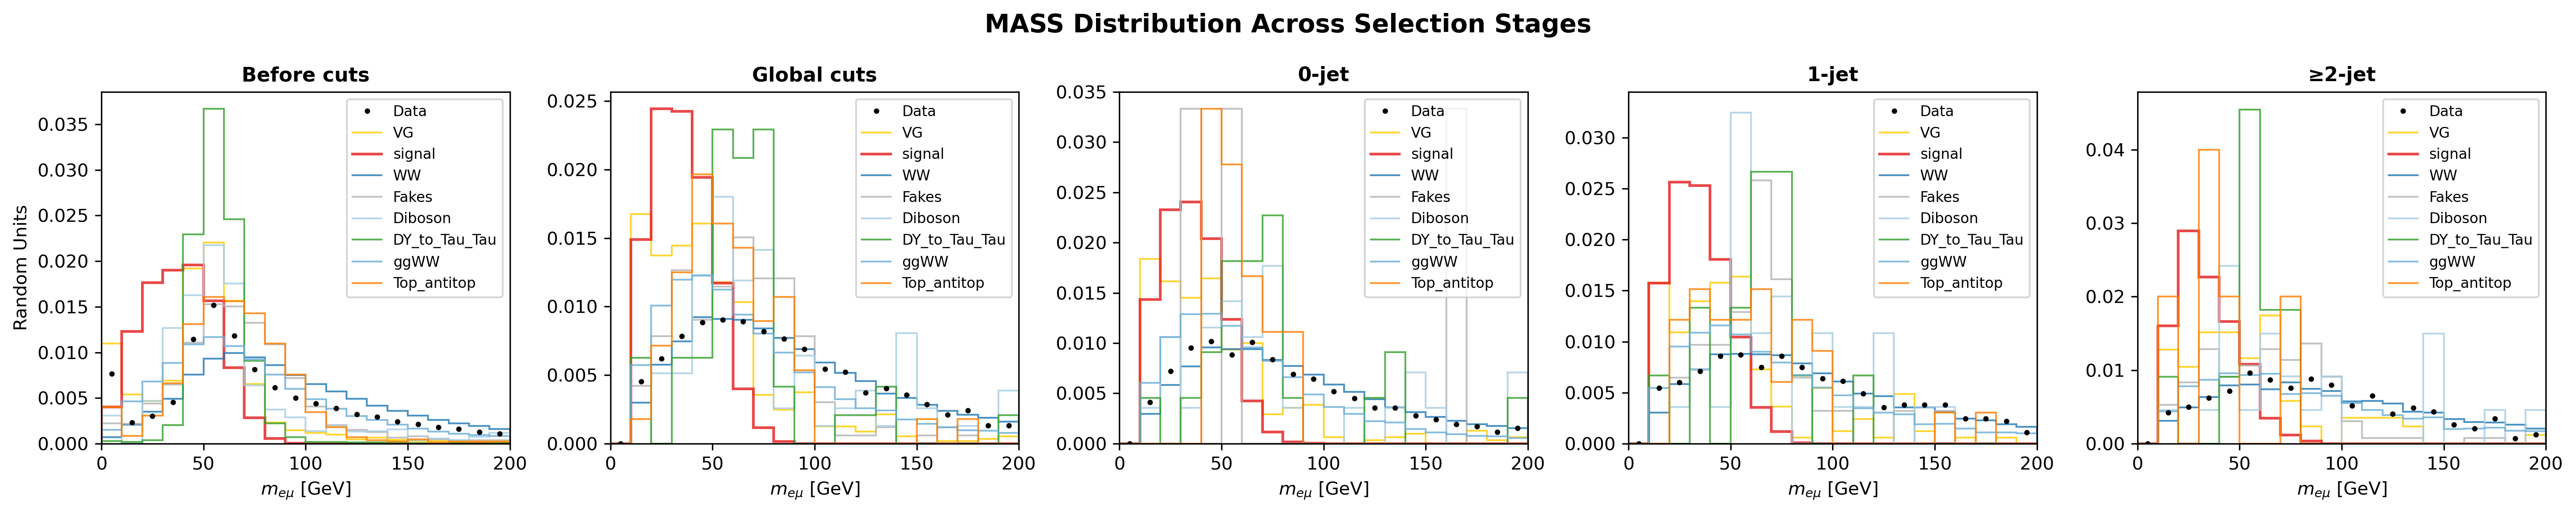


Plotting met...


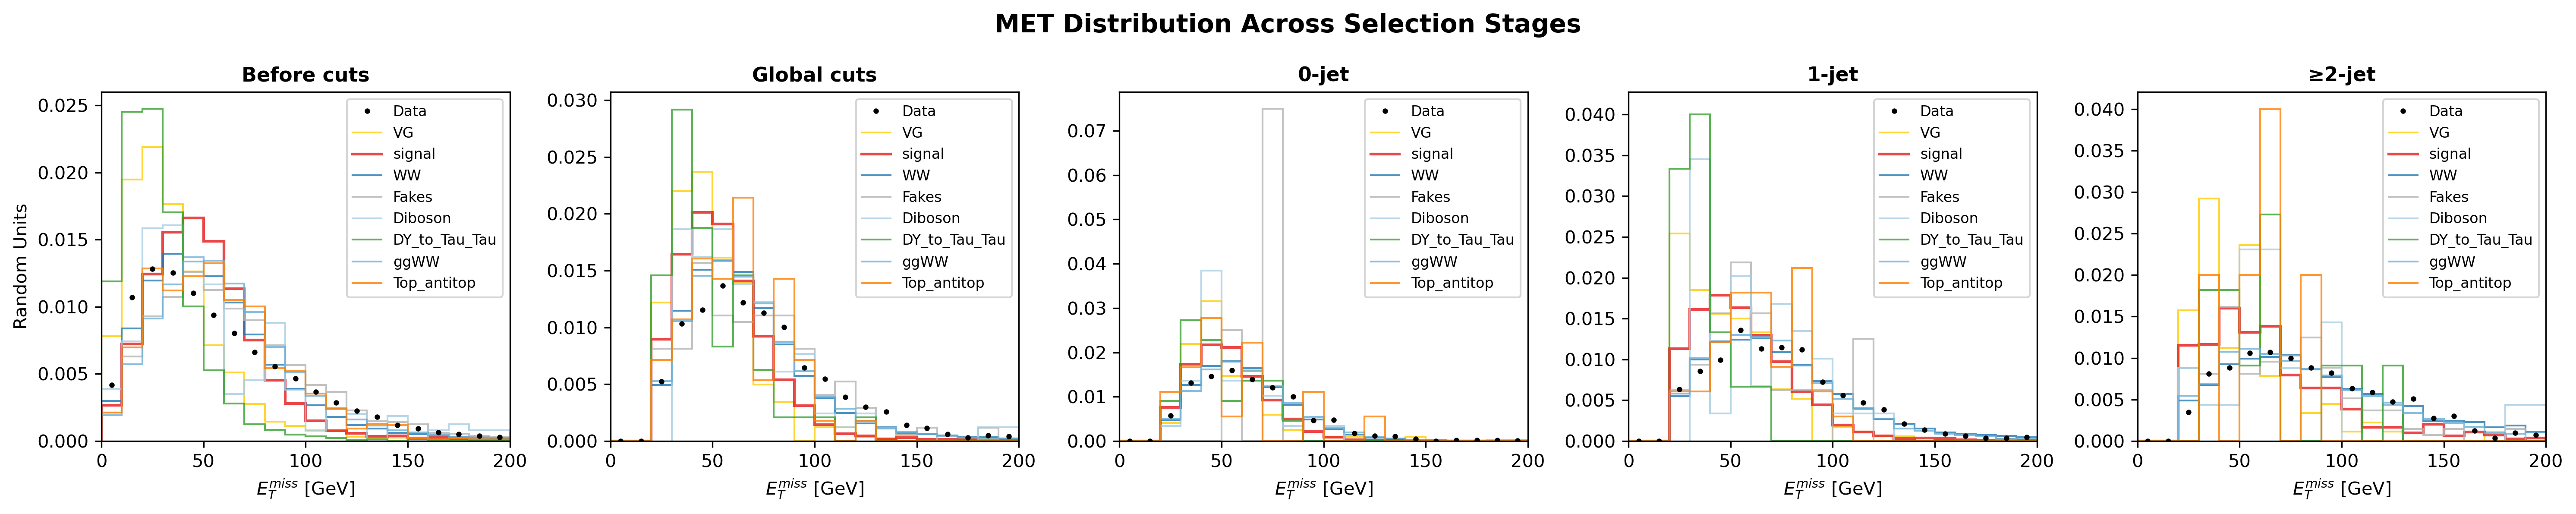


Plotting dphi...


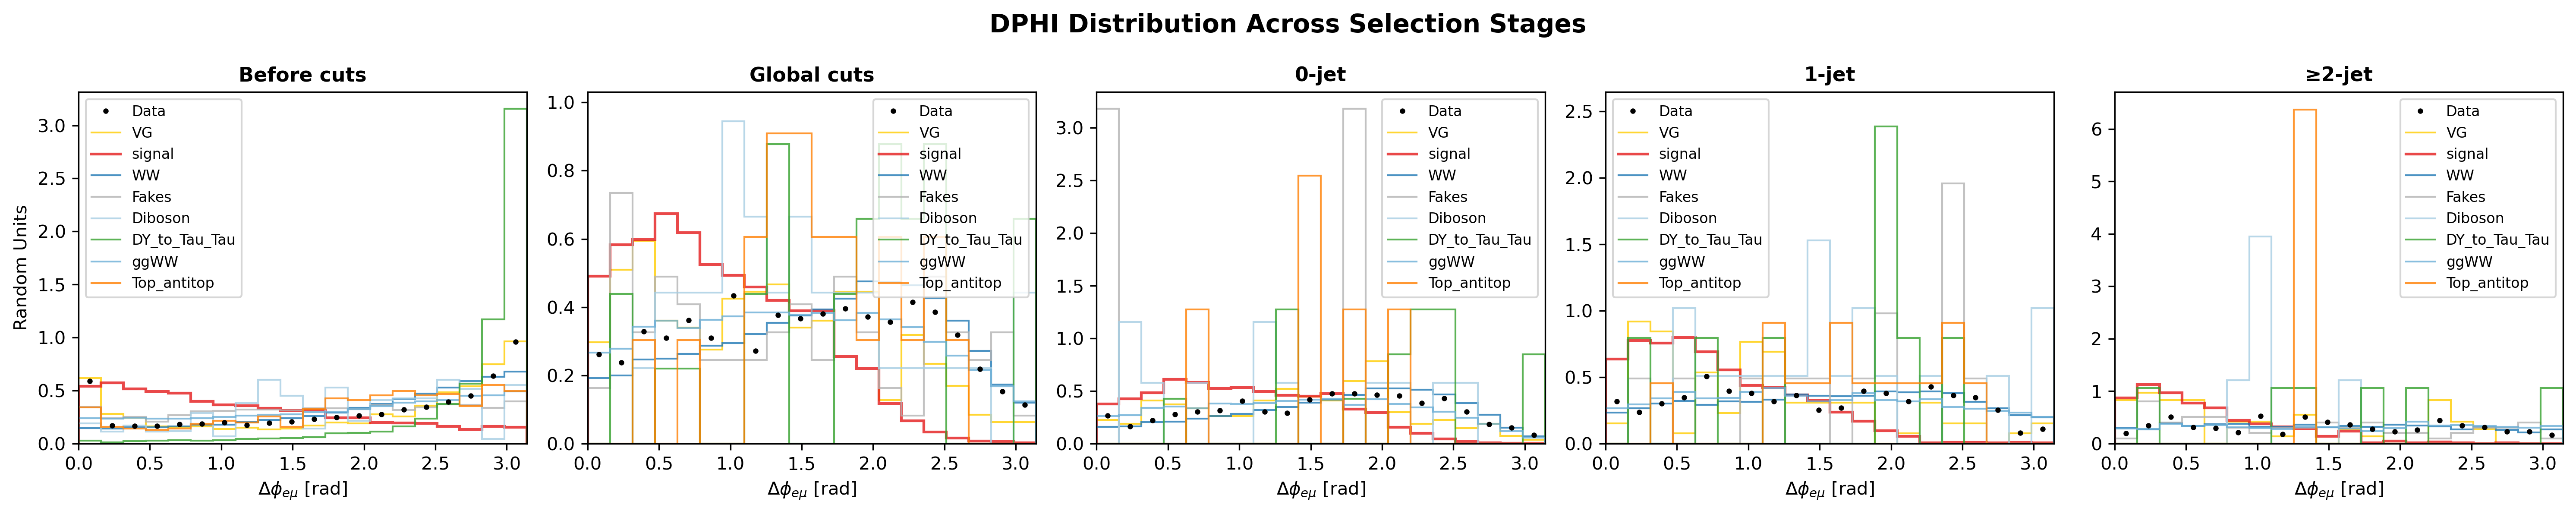


Plotting ptll...


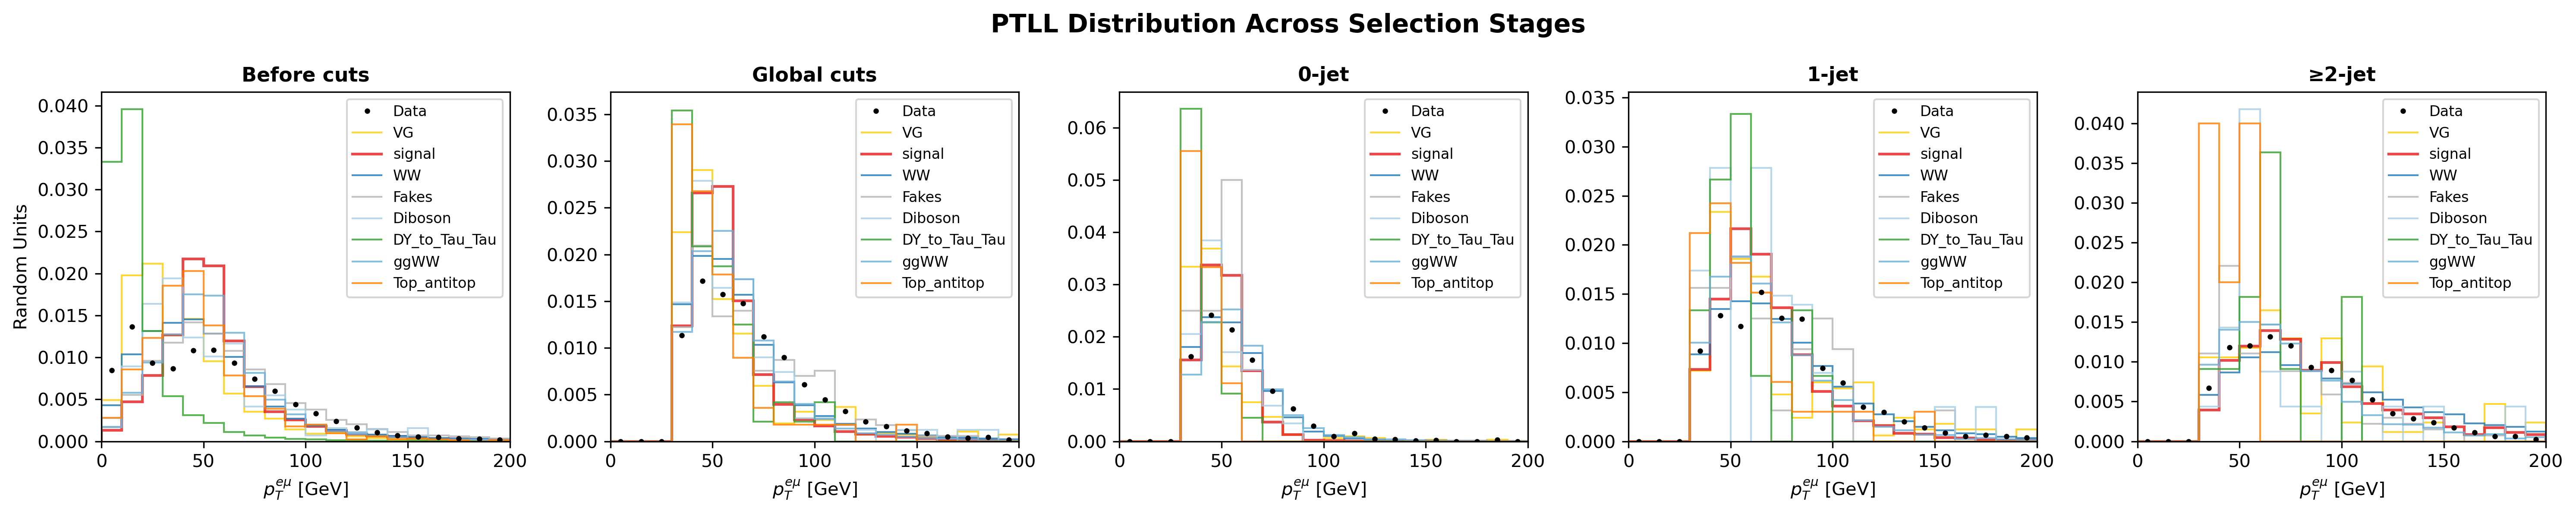


Plotting mt_higgs...


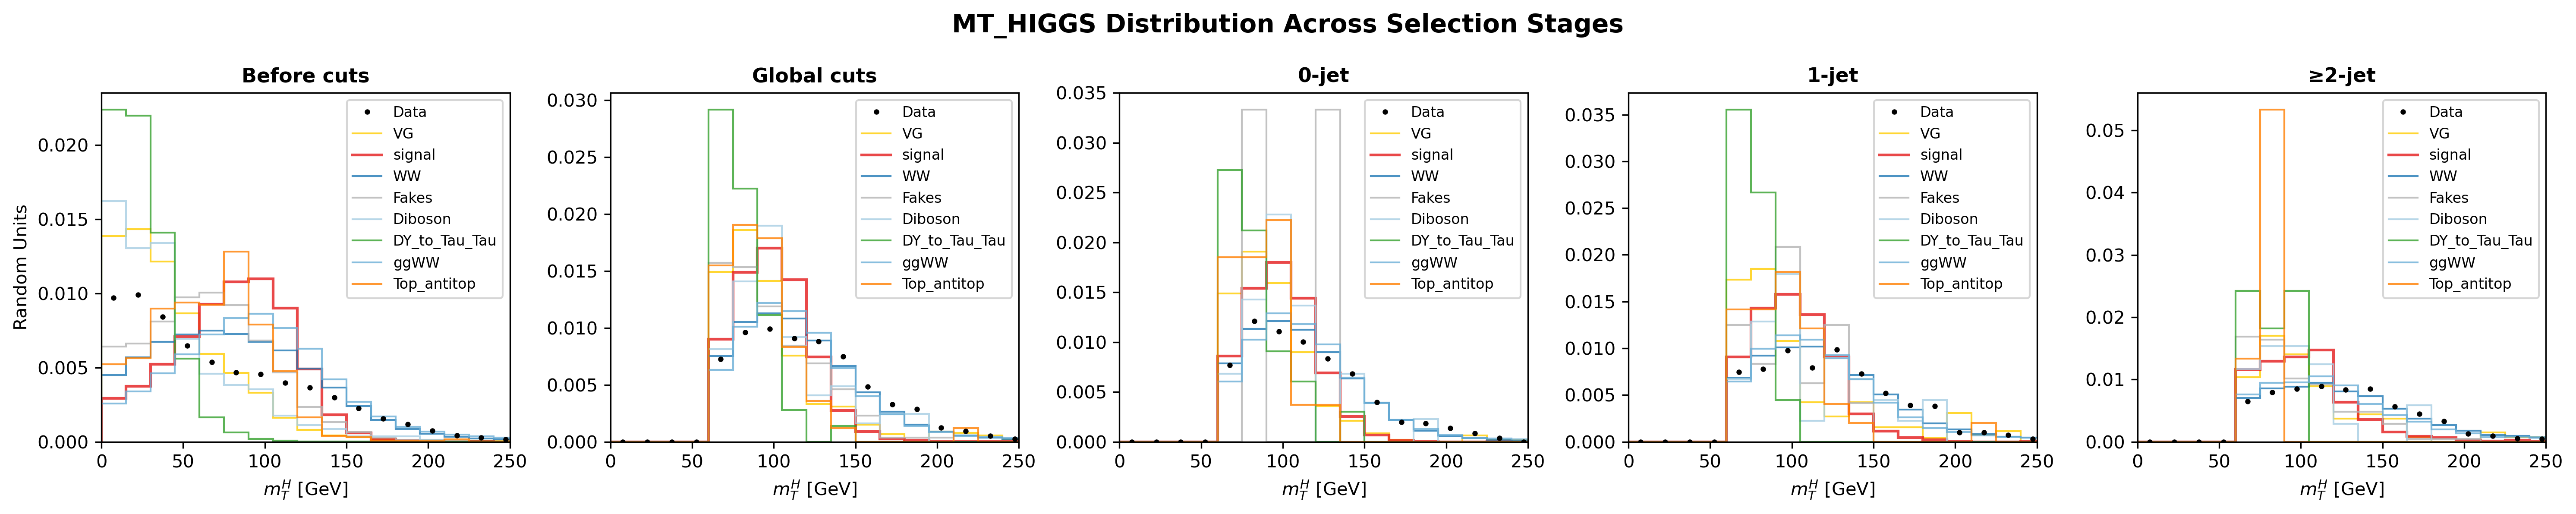


Plotting mt_l2_met...


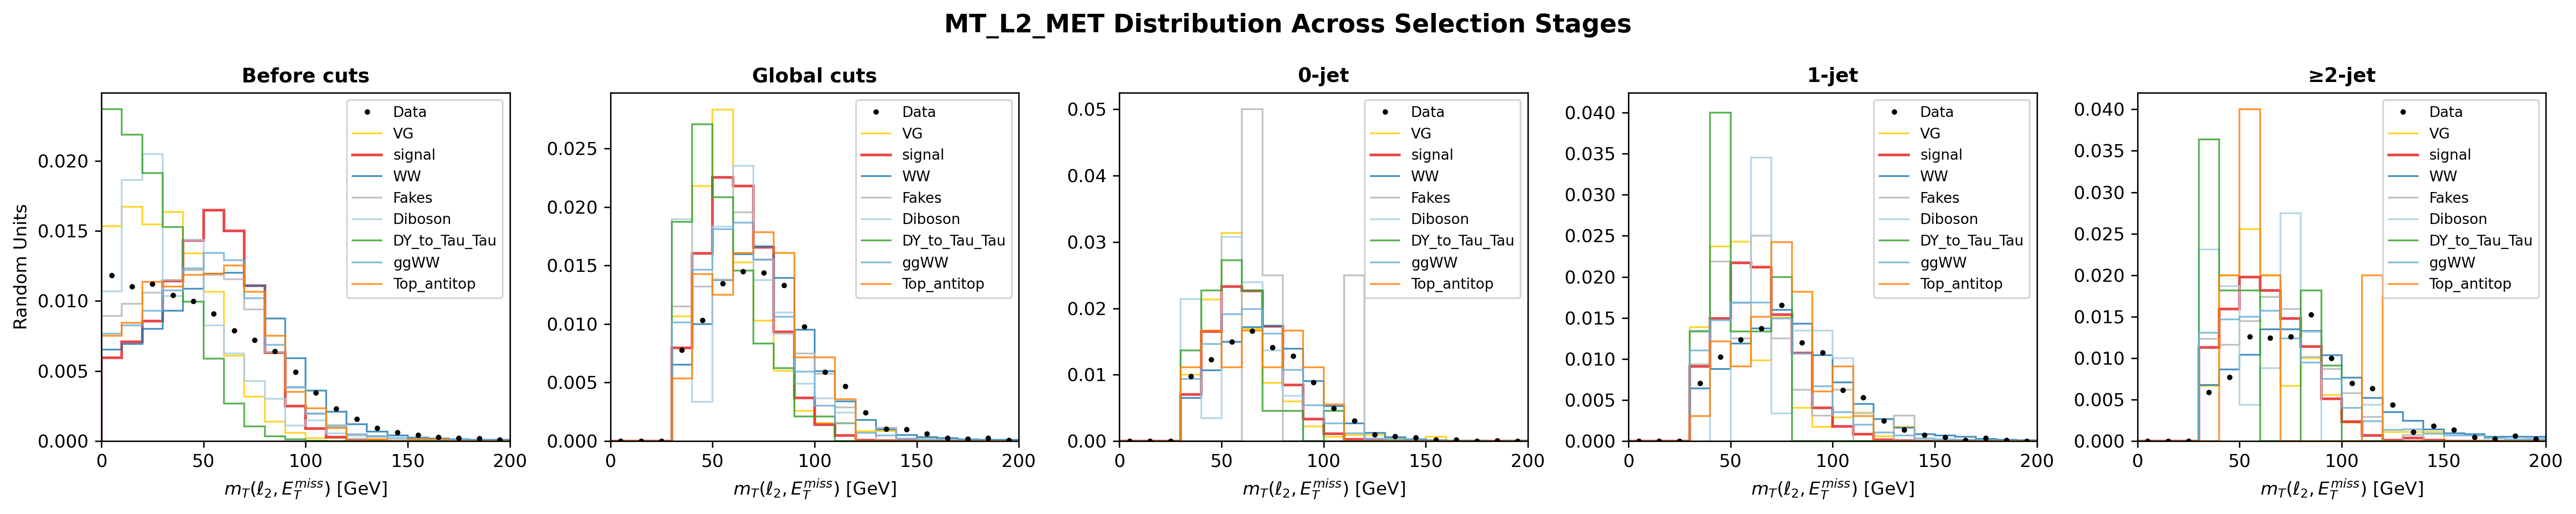


Plotting mjj...


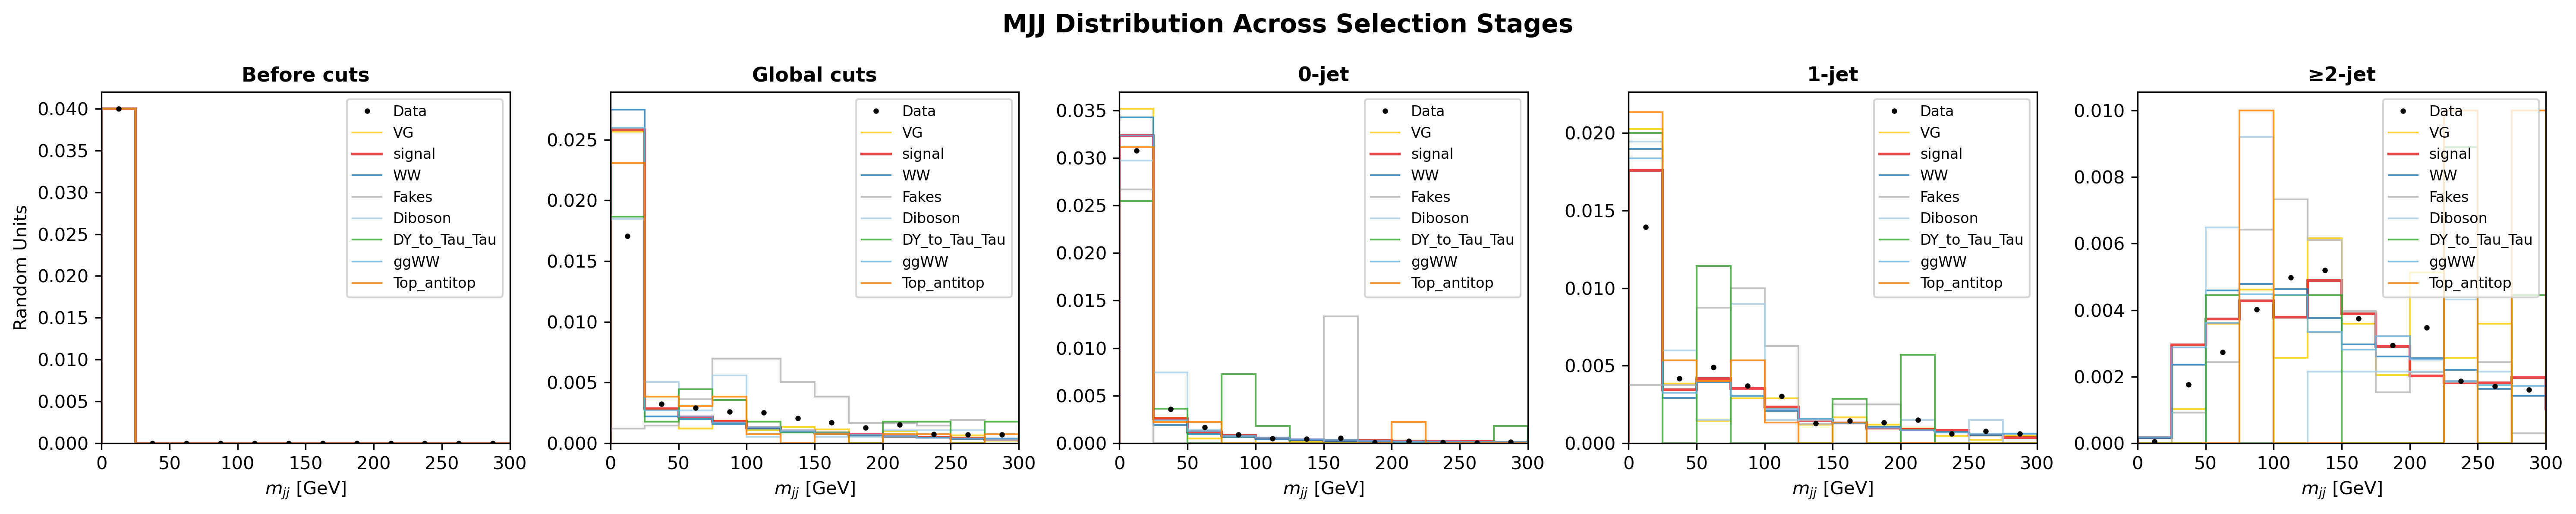

In [79]:
# Plot all variables
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final)
    plt.show()

### Stacked plots

In [85]:
def get_backgrounds_and_signal():
    """Return list of background samples and signal sample sorted by stack_order"""
    
    # Get all background samples with their stack_order
    backgrounds = []
    for sample, props in SAMPLES.items():
        if not props["is_signal"] and props["stack_order"] is not None:
            backgrounds.append((sample, props["stack_order"]))
    
    # Sort by stack_order (ascending: 0 at bottom, highest at top)
    backgrounds.sort(key=lambda x: x[1])
    backgrounds = [sample for sample, _ in backgrounds]
    
    # Get signal
    signal = None
    for sample, props in SAMPLES.items():
        if props["is_signal"]:
            signal = sample
            break
    
    return backgrounds, signal


def get_data_sample():
    """Return the data sample"""
    return 'Data'


def get_histogram_data(hist_data_all, sample, stage, hist_key):
    """Get histogram data, return None if not available."""
    try:
        hist = hist_data_all[sample][stage][hist_key]
        if hist.sum() == 0:
            return None, None
        
        values = hist.values()
        edges = hist.axes[0].edges
        
        return values, edges
    except (KeyError, AttributeError):
        return None, None

In [86]:
def plot_sr_cr_stacked(variable, var_props, hist_data_all):
    """
    Plot stacked histograms for all Signal Regions (SR) and Control Regions (CR).
    
    Parameters:
    -----------
    variable : str
        Variable name to plot (e.g., 'mass', 'met', 'ptll')
    var_props : dict
        Plot properties with keys:
        - 'xlabel': str - x-axis label
        - 'xlim': tuple - (xmin, xmax) or None for auto
        - 'title': str - main title for the plot
        - 'use_log_scale': bool - use log scale on y-axis (default: False)
        - 'y_padding': float - padding factor for y-axis max (default: 1.3)
        - 'plot_data_in_SR': bool - show data in Signal Regions (default: False)
    hist_data_all : dict
        Histogram data from processing (already scaled!)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    
    # Extract custom options with defaults
    use_log_scale = var_props.get('use_log_scale', False)
    y_padding = var_props.get('y_padding', 1.3)
    plot_data_in_SR = var_props.get('plot_data_in_SR', False)
    xlabel = var_props.get('xlabel', variable)
    xlim = var_props.get('xlim', None)
    title = var_props.get('title', f'{variable.upper()} Distribution')
    
    # Define regions to plot
    regions = [
        ('SR_0jet', 'SR 0-jet'), 
        ('SR_1jet', 'SR 1-jet'), 
        ('SR_2jet', 'SR 2-jet'),
        ('CR_top_0jet', 'Top CR 0-jet'), 
        ('CR_top_1jet', 'Top CR 1-jet'), 
        ('CR_top_2jet', 'Top CR 2-jet'), 
        ('CR_tau_0jet', 'ττ CR 0-jet'),
        ('CR_tau_1jet', 'ττ CR 1-jet'), 
        ('CR_tau_2jet', 'ττ CR 2-jet')
    ]

    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=(20, 16), dpi=150)
    axes = axes.flatten()

    # Get sample lists
    backgrounds, signal = get_backgrounds_and_signal()
    data_sample = get_data_sample()

    # Legend tracking
    legend_handles = {}
    legend_created = False

    print(f"Caching histogram data for {variable}...")
    samples_to_cache = backgrounds + [signal, data_sample]
    
    hist_cache = {}
    for sample in samples_to_cache:
        hist_cache[sample] = {}
        for stage, _ in regions:
            values, edges = get_histogram_data(
                hist_data_all, sample, stage, variable
            )
            if values is not None and edges is not None:
                hist_cache[sample][stage] = (values, edges)

    # Plot each region
    for idx, (stage, stage_label) in enumerate(regions):
        ax = axes[idx]

        # Get bin edges from first available sample
        edges = None
        for sample in hist_cache:
            if stage in hist_cache[sample]:
                _, edges = hist_cache[sample][stage]
                break

        # Handle empty regions
        if edges is None:
            ax.text(
                0.5, 0.5, 'No data', 
                ha='center', va='center', 
                transform=ax.transAxes, 
                fontsize=12,
                color='gray'
            )
            ax.set_title(stage_label, fontsize=12, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=11)
            ax.set_ylabel('Events', fontsize=11)
            continue

        # ========================================
        # PLOT STACKED BACKGROUNDS (NO SIGNAL)
        # ========================================
        bg_values = []
        bg_colors = []
        bg_labels = []
        
        for sample in backgrounds:
            if sample in hist_cache and stage in hist_cache[sample]:
                values, _ = hist_cache[sample][stage]
                bg_values.append(values)
                bg_colors.append(SAMPLES[sample]["color"])
                bg_labels.append(sample)

        if bg_values:
            ax.hist(
                [edges[:-1] for _ in bg_values], 
                bins=edges, 
                weights=bg_values,
                stacked=True, 
                color=bg_colors,
                histtype='stepfilled', 
                alpha=1.0, 
                edgecolor='none', 
                linewidth=0.5
            )
            
            # Create legend handles for backgrounds (once)
            if not legend_created:
                for i, label in enumerate(bg_labels):
                    legend_handles[label] = mpatches.Patch(
                        facecolor=bg_colors[i],
                        edgecolor='none',
                        label=label
                    )

        # ========================================
        # PLOT SIGNAL AS RED OUTLINE (NOT STACKED)
        # ========================================
        if signal in hist_cache and stage in hist_cache[signal]:
            signal_values, _ = hist_cache[signal][stage]
            
            # Plot signal as unfilled histogram with red outline
            ax.hist(
                edges[:-1], 
                bins=edges, 
                weights=signal_values, 
                histtype='step',
                color=SAMPLES[signal]["color"],  # Red color
                linewidth=2.5,
                zorder=10  # On top of everything
            )
            
            # Create legend handle for signal (once)
            if not legend_created:
                legend_handles[signal] = plt.Line2D(
                    [0], [0], 
                    color=SAMPLES[signal]["color"], 
                    linewidth=2.5,
                    label=signal
                )

        # ========================================
        # PLOT DATA 
        # ========================================
        PLOT_DATA = True  # SET TO False TO HIDE DATA EVERYWHERE
        
        # Check if current region is a Control Region (CR)
        is_control_region = stage.startswith('CR_')
        
        # Determine if we should plot data in this region
        should_plot_data = PLOT_DATA and (is_control_region or plot_data_in_SR)
        
        if should_plot_data:
            if data_sample in hist_cache and stage in hist_cache[data_sample]:
                data_values, _ = hist_cache[data_sample][stage]
                centers = 0.5 * (edges[:-1] + edges[1:])
                
                # Plot data points
                ax.errorbar(
                    centers, 
                    data_values,
                    yerr=np.sqrt(data_values),  # Poisson errors
                    fmt='o',                    # Circle markers
                    color='black',              
                    markersize=5,               # Thicker markers
                    markerfacecolor='black',    # Filled markers
                    markeredgewidth=0,          # No marker edge
                    elinewidth=1.2,             # Thin error bar lines
                    capsize=2.5,                # Subtle caps
                    capthick=1.2,               # Cap thickness matches error bars
                    linewidth=0,                # No connecting line
                    zorder=10
                )
                
                # Create legend handle for data 
                if not legend_created:
                    legend_handles[data_sample] = plt.Line2D(
                        [0], [0], 
                        marker='o', 
                        color='black', 
                        markersize=6,
                        linestyle='none',
                        label=data_sample
                    )
                
                # Print Data/MC ratio 
                if bg_values:
                    total_mc = np.sum(bg_values, axis=0)
                    total_mc_events = np.sum(total_mc)
                    total_data_events = np.sum(data_values)
                    
                    if total_mc_events > 0:
                        ratio = total_data_events / total_mc_events
                        print(f"  {stage:15s}: Data/MC = {ratio:.3f} "
                              f"(Data: {total_data_events:8.1f}, MC: {total_mc_events:8.1f})")

        # Mark legend as created
        if not legend_created and legend_handles:
            legend_created = True

        # ========================================
        # SET  X-AXIS LIMITS
        # ========================================
        all_values = []
        
        # Collect all histogram values
        for sample in backgrounds:
            if sample in hist_cache and stage in hist_cache[sample]:
                values, _ = hist_cache[sample][stage]
                all_values.append(values)
        
        # Include signal separately 
        if signal in hist_cache and stage in hist_cache[signal]:
            sig_values, _ = hist_cache[signal][stage]
            all_values.append(sig_values)
        
        # Only include data in xlim calculation if plotting it
        if should_plot_data and data_sample in hist_cache and stage in hist_cache[data_sample]:
            data_values, _ = hist_cache[data_sample][stage]
            all_values.append(data_values)
        
        # Apply xlim from var_props 
        if xlim is not None:
            ax.set_xlim(xlim)
        elif all_values:
            # Find range with non-zero content
            combined = np.maximum.reduce(all_values)
            non_zero_bins = np.where(combined > 0)[0]
            
            if len(non_zero_bins) > 0:
                # Add padding
                first_bin = max(0, non_zero_bins[0] - 1)
                last_bin = min(len(edges) - 1, non_zero_bins[-1] + 2)
                ax.set_xlim(edges[first_bin], edges[last_bin])
            else:
                ax.set_xlim(edges[0], edges[-1])
        else:
            ax.set_xlim(edges[0], edges[-1])

        # ========================================
        # SET Y-AXIS (LOG OR LINEAR SCALE)
        # ========================================
        
        # Calculate sensible y-limits
        y_max = 0
        if bg_values:
            y_max = max(y_max, np.max(np.sum(bg_values, axis=0)))
        
        # Check signal separately (not part of stack)
        if signal in hist_cache and stage in hist_cache[signal]:
            sig_values, _ = hist_cache[signal][stage]
            y_max = max(y_max, np.max(sig_values))
        
        # Include data if plotted
        if should_plot_data and data_sample in hist_cache and stage in hist_cache[data_sample]:
            data_values, _ = hist_cache[data_sample][stage]
            y_max = max(y_max, np.max(data_values))
        
        # Set scale and limits based on var_props
        if use_log_scale:
            ax.set_yscale('log')
            if y_max > 0:
                ax.set_ylim(1.0, y_max * y_padding)  
            else:
                ax.set_ylim(1.0, 1000)
        else:
            # Linear scale
            if y_max > 0:
                ax.set_ylim(0.0, y_max * y_padding)
            else:
                ax.set_ylim(0.0, 100)

        # ========================================
        # AXIS LABELS AND STYLING
        # ========================================
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Events', fontsize=11)
        ax.set_title(stage_label, fontsize=12, fontweight='bold')
        ax.tick_params(labelsize=10)

    # ========================================
    # CREATE SHARED LEGEND
    # ========================================
    ordered_handles = []
    ordered_labels = []
    
    # Data first 
    if PLOT_DATA and data_sample in legend_handles:
        ordered_handles.append(legend_handles[data_sample])
        ordered_labels.append(data_sample)
    
    # Signal second 
    if signal in legend_handles:
        ordered_handles.append(legend_handles[signal])
        ordered_labels.append(signal)
    
    # Backgrounds
    for sample in reversed(backgrounds):
        if sample in legend_handles:
            ordered_handles.append(legend_handles[sample])
            ordered_labels.append(sample)

    # Add legend to figure
    if ordered_handles:
        fig.legend(
            ordered_handles, 
            ordered_labels,
            loc='center right', 
            bbox_to_anchor=(0.98, 0.5),
            fontsize=11, 
            frameon=True, 
            fancybox=True,
            shadow=True,
            title='Samples', 
            title_fontsize=12
        )

    # ========================================
    # OVERALL TITLE
    # ========================================
    main_title = f'{title} - Signal & Control Regions'
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.98)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.87, 0.96])

    print(f"Plot complete for {variable}")
    
    return fig

In [87]:
# # =============================================================================
# # PLOTTING FUNCTIONS - ONE PER VARIABLE
# # =============================================================================

# def plot_mass_distribution(hist_data_all):
#     """Plot mass (m_emu) distribution across all regions"""
    
#     variable = 'mass'
#     var_props = {
#         'xlabel': r'$m_{e\mu}$ [GeV]',
#         'xlim': (25, 200),
#         'title': 'Invariant Mass Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


# def plot_met_distribution(hist_data_all):
#     """Plot Missing ET distribution across all regions"""
    
#     variable = 'met'
#     var_props = {
#         'xlabel': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
#         'xlim': (0, 150),
#         'title': 'Missing Transverse Energy Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


# def plot_ptll_distribution(hist_data_all):
#     """Plot p_T(ll) distribution across all regions"""
    
#     variable = 'ptll'
#     var_props = {
#         'xlabel': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
#         'xlim': (0, 200),
#         'title': 'Dilepton Transverse Momentum Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


# def plot_dphi_distribution(hist_data_all):
#     """Plot del phi(e,mu) distribution across all regions"""
    
#     variable = 'dphi'
#     var_props = {
#         'xlabel': r'$\Delta\phi(e,\mu)$ [rad]',
#         'xlim': (0, 3.2),
#         'title': 'Azimuthal Angle Difference Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


# def plot_mt_distribution(hist_data_all):
#     """Plot Transverse mass distribution across all regions"""
    
#     variable = 'mt'
#     var_props = {
#         'xlabel': r'$m_{\mathrm{T}}$ [GeV]',
#         'xlim': (0, 300),
#         'title': 'Transverse Mass Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig



# def plot_pt_leading_lepton(hist_data_all):
#     """Plot leading lepton p_T distribution across all regions"""
    
#     variable = 'pt_leading_lep'
#     var_props = {
#         'xlabel': r'$p_{\mathrm{T}}^{\mathrm{leading}}$ [GeV]',
#         'xlim': (20, 200),
#         'title': 'Leading Lepton Transverse Momentum Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


# def plot_pt_subleading_lepton(hist_data_all):
#     """Plot subleading lepton p_T distribution across all regions"""
    
#     variable = 'pt_subleading_lep'
#     var_props = {
#         'xlabel': r'$p_{\mathrm{T}}^{\mathrm{subleading}}$ [GeV]',
#         'xlim': (10, 150),
#         'title': 'Subleading Lepton Transverse Momentum Distribution',
#         'use_log_scale': False,
#         'y_padding': 1.3,
#         'plot_data_in_SR': False
#     }
    
#     fig = plot_sr_cr_stacked(variable, var_props, hist_data_all)
#     return fig


GENERATING ALL DISTRIBUTION PLOTS

 Plotting mass...
Caching histogram data for mass...
  CR_top_0jet    : Data/MC = 1.309 (Data:     58.0, MC:     44.3)
  CR_top_1jet    : Data/MC = 13.282 (Data:    170.0, MC:     12.8)
  CR_top_2jet    : Data/MC = 26.741 (Data:     67.0, MC:      2.5)
  CR_tau_0jet    : Data/MC = 0.784 (Data:     23.0, MC:     29.3)
  CR_tau_1jet    : Data/MC = 1.465 (Data:     50.0, MC:     34.1)
  CR_tau_2jet    : Data/MC = 2.562 (Data:      6.0, MC:      2.3)
Plot complete for mass
    Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions/mass_distribution.png


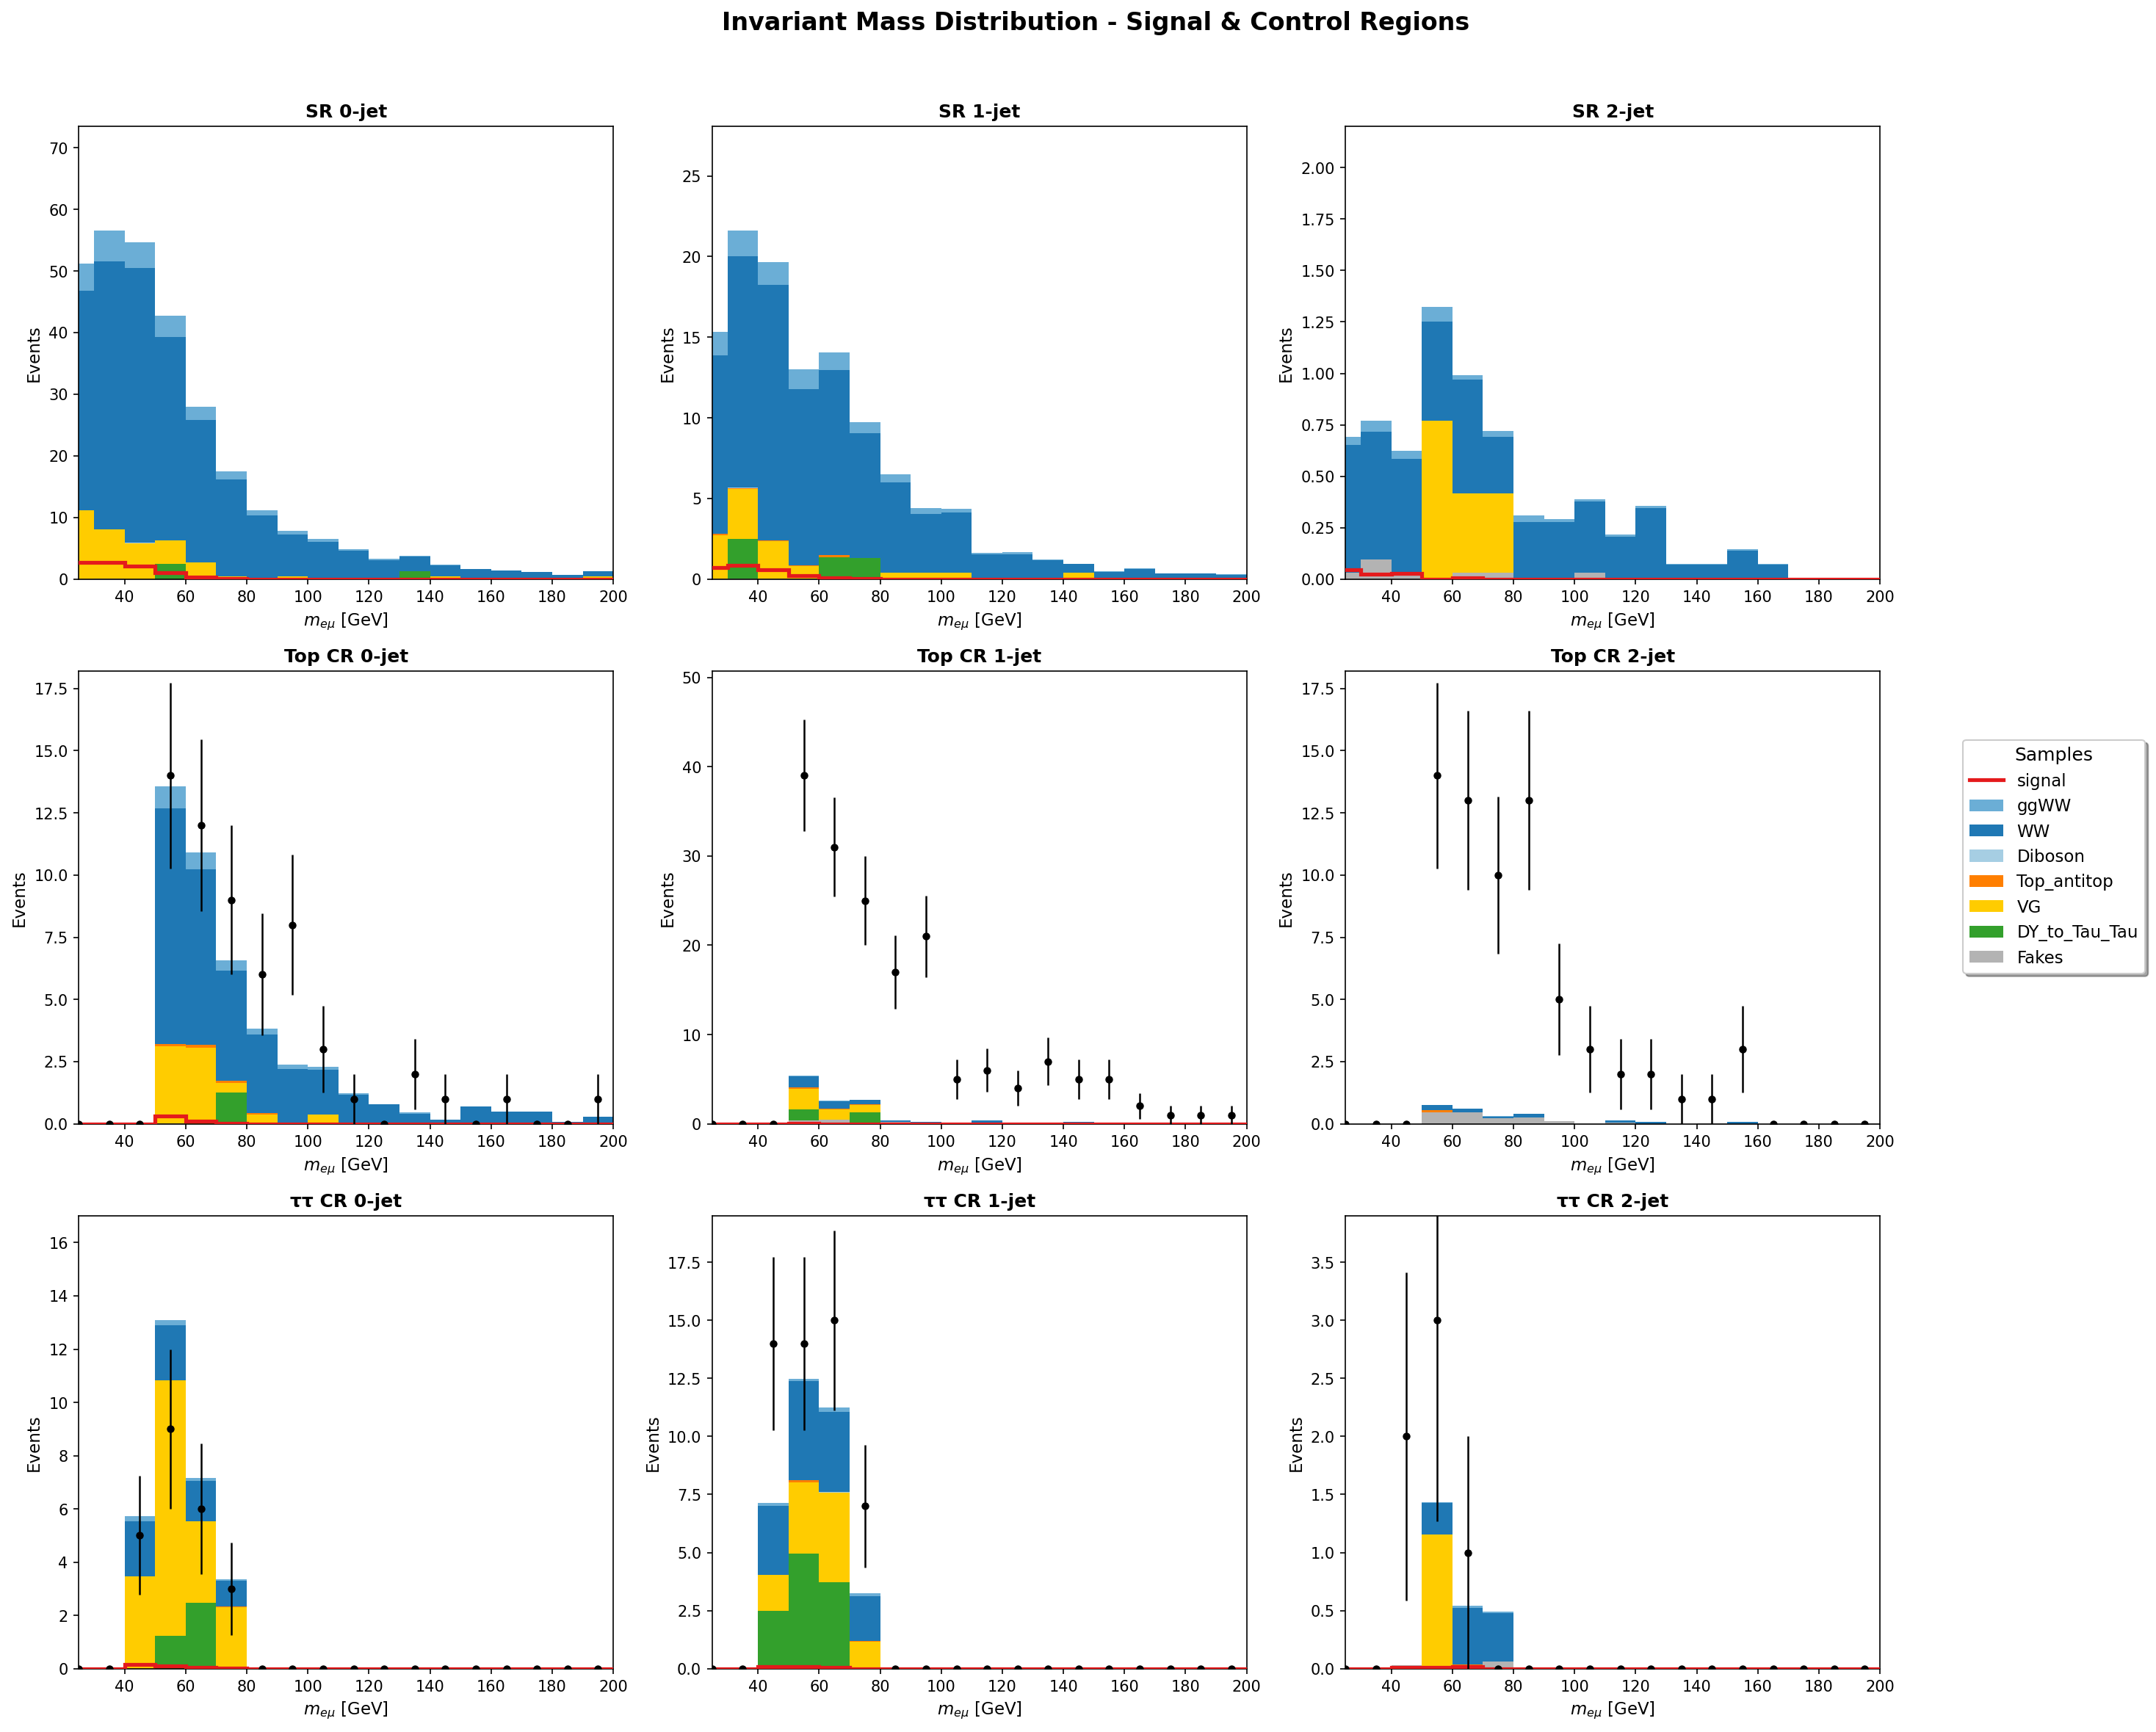


 Plotting met...
Caching histogram data for met...
  CR_top_0jet    : Data/MC = 1.263 (Data:     57.0, MC:     45.1)
  CR_top_1jet    : Data/MC = 13.439 (Data:    172.0, MC:     12.8)
  CR_top_2jet    : Data/MC = 26.342 (Data:     66.0, MC:      2.5)
  CR_tau_0jet    : Data/MC = 0.784 (Data:     23.0, MC:     29.3)
  CR_tau_1jet    : Data/MC = 1.477 (Data:     50.0, MC:     33.8)
  CR_tau_2jet    : Data/MC = 2.562 (Data:      6.0, MC:      2.3)
Plot complete for met
    Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions/met_distribution.png


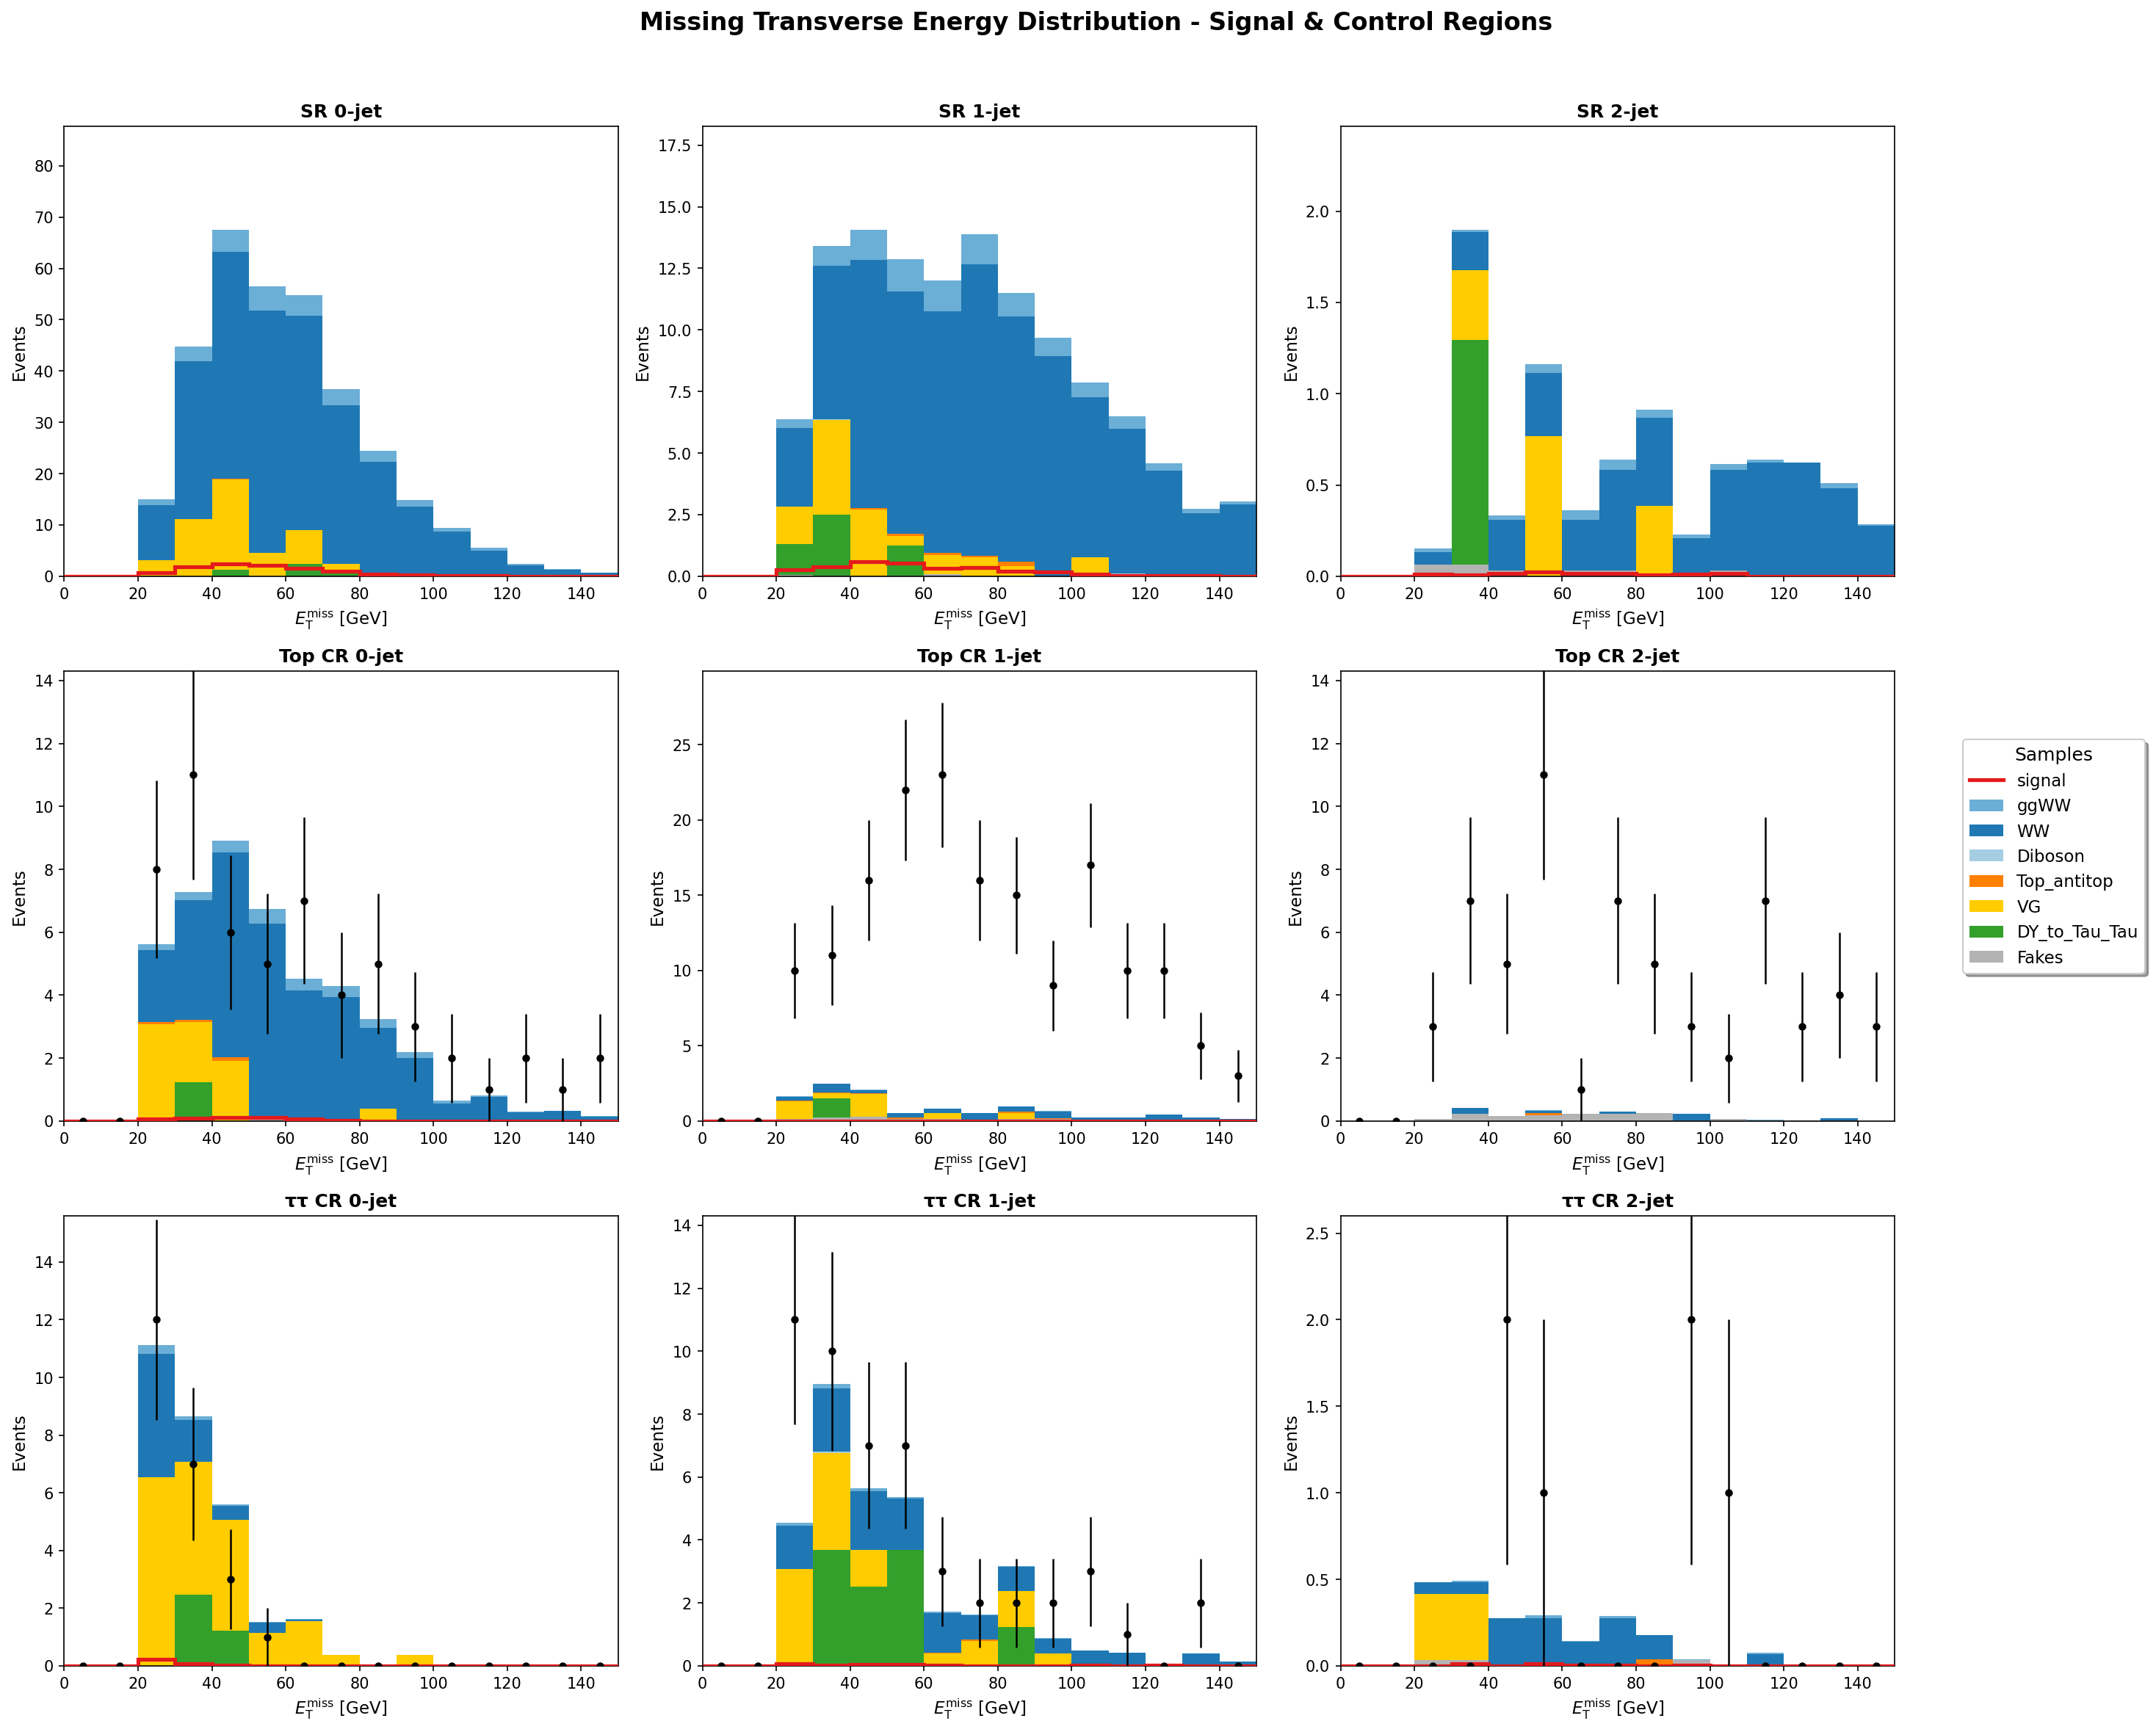


 Plotting ptll...
Caching histogram data for ptll...
  CR_top_0jet    : Data/MC = 1.241 (Data:     56.0, MC:     45.1)
  CR_top_1jet    : Data/MC = 13.433 (Data:    171.0, MC:     12.7)
  CR_top_2jet    : Data/MC = 27.140 (Data:     68.0, MC:      2.5)
  CR_tau_0jet    : Data/MC = 0.784 (Data:     23.0, MC:     29.3)
  CR_tau_1jet    : Data/MC = 1.465 (Data:     50.0, MC:     34.1)
  CR_tau_2jet    : Data/MC = 2.562 (Data:      6.0, MC:      2.3)
Plot complete for ptll
    Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions/ptll_distribution.png


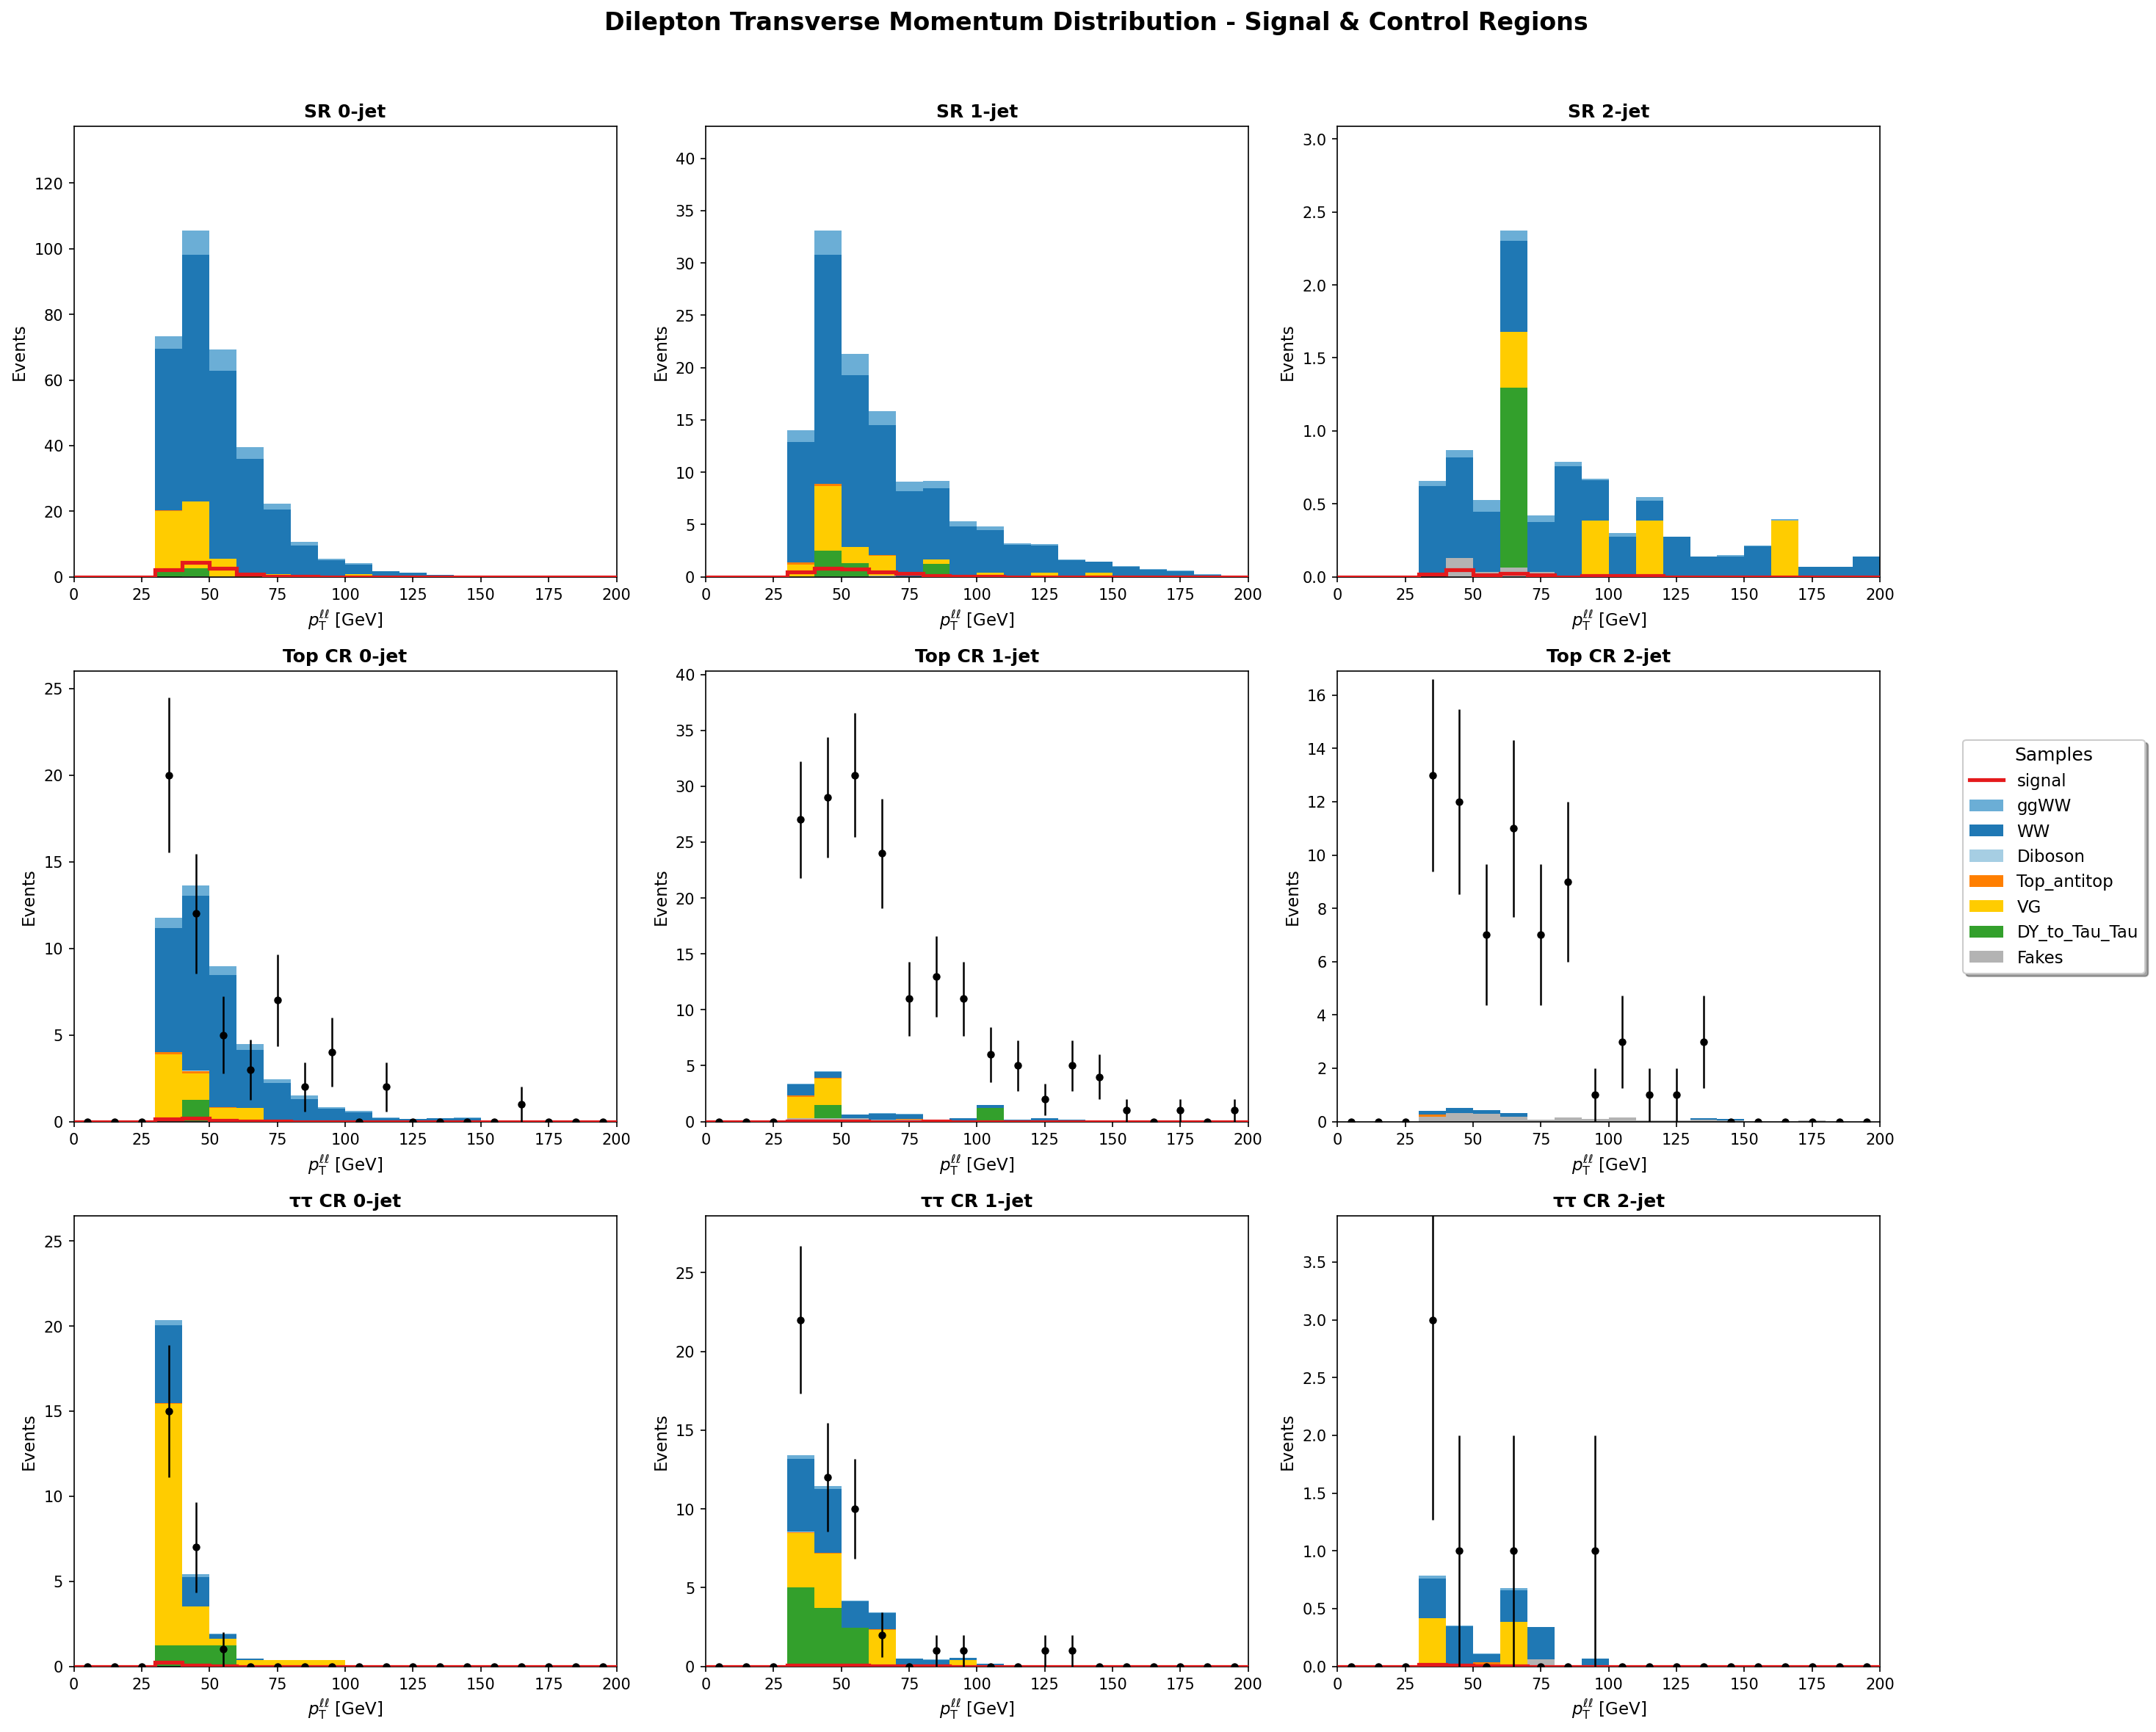


 Plotting dphi...
Caching histogram data for dphi...
  CR_top_0jet    : Data/MC = 1.144 (Data:     25.0, MC:     21.9)
  CR_top_1jet    : Data/MC = 13.410 (Data:     93.0, MC:      6.9)
  CR_top_2jet    : Data/MC = 31.764 (Data:     43.0, MC:      1.4)
  CR_tau_0jet    : Data/MC = 0.866 (Data:     12.0, MC:     13.8)
  CR_tau_1jet    : Data/MC = 1.650 (Data:     24.0, MC:     14.5)
  CR_tau_2jet    : Data/MC = 2.471 (Data:      3.0, MC:      1.2)
Plot complete for dphi
    Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions/dphi_distribution.png


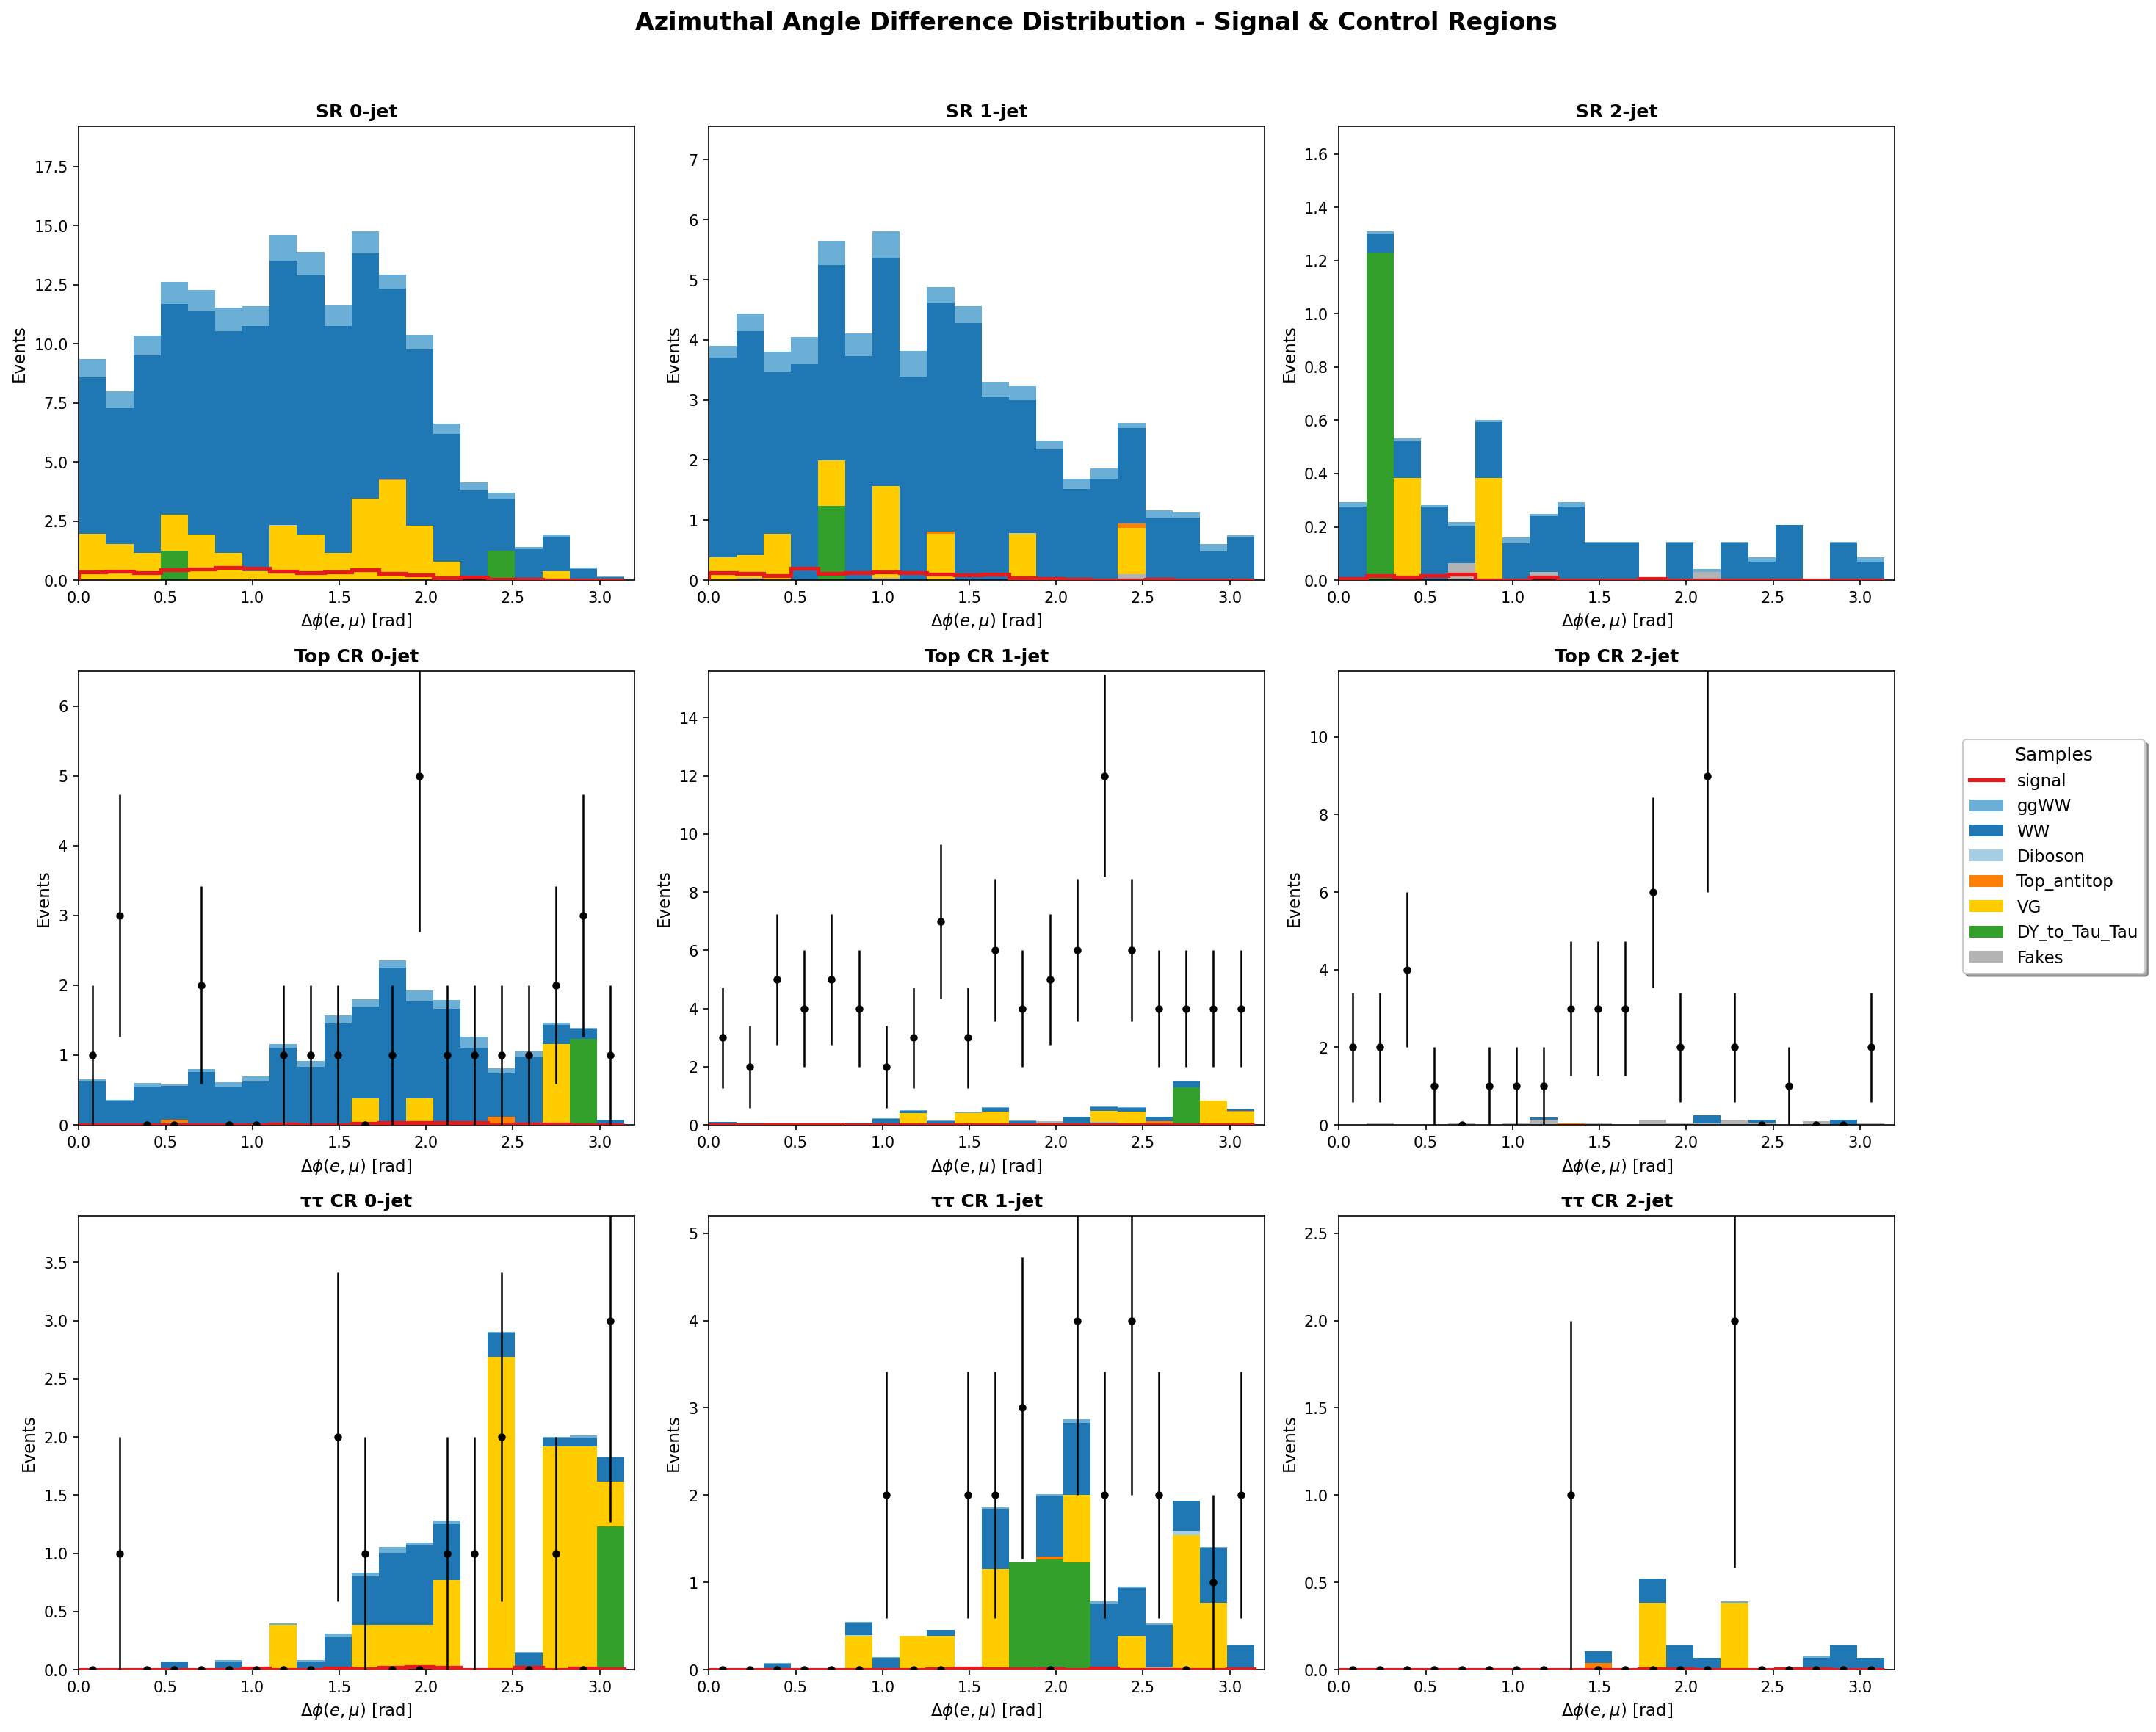


 Plotting mt...
Caching histogram data for mt...
    Error plotting mt: cannot access local variable 'PLOT_DATA' where it is not associated with a value

 Plotting pt_leading_lep...
Caching histogram data for pt_leading_lep...
    Error plotting pt_leading_lep: cannot access local variable 'PLOT_DATA' where it is not associated with a value

 Plotting pt_subleading_lep...
Caching histogram data for pt_subleading_lep...
    Error plotting pt_subleading_lep: cannot access local variable 'PLOT_DATA' where it is not associated with a value

 ALL PLOTS GENERATED SUCCESSFULLY
 Plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions



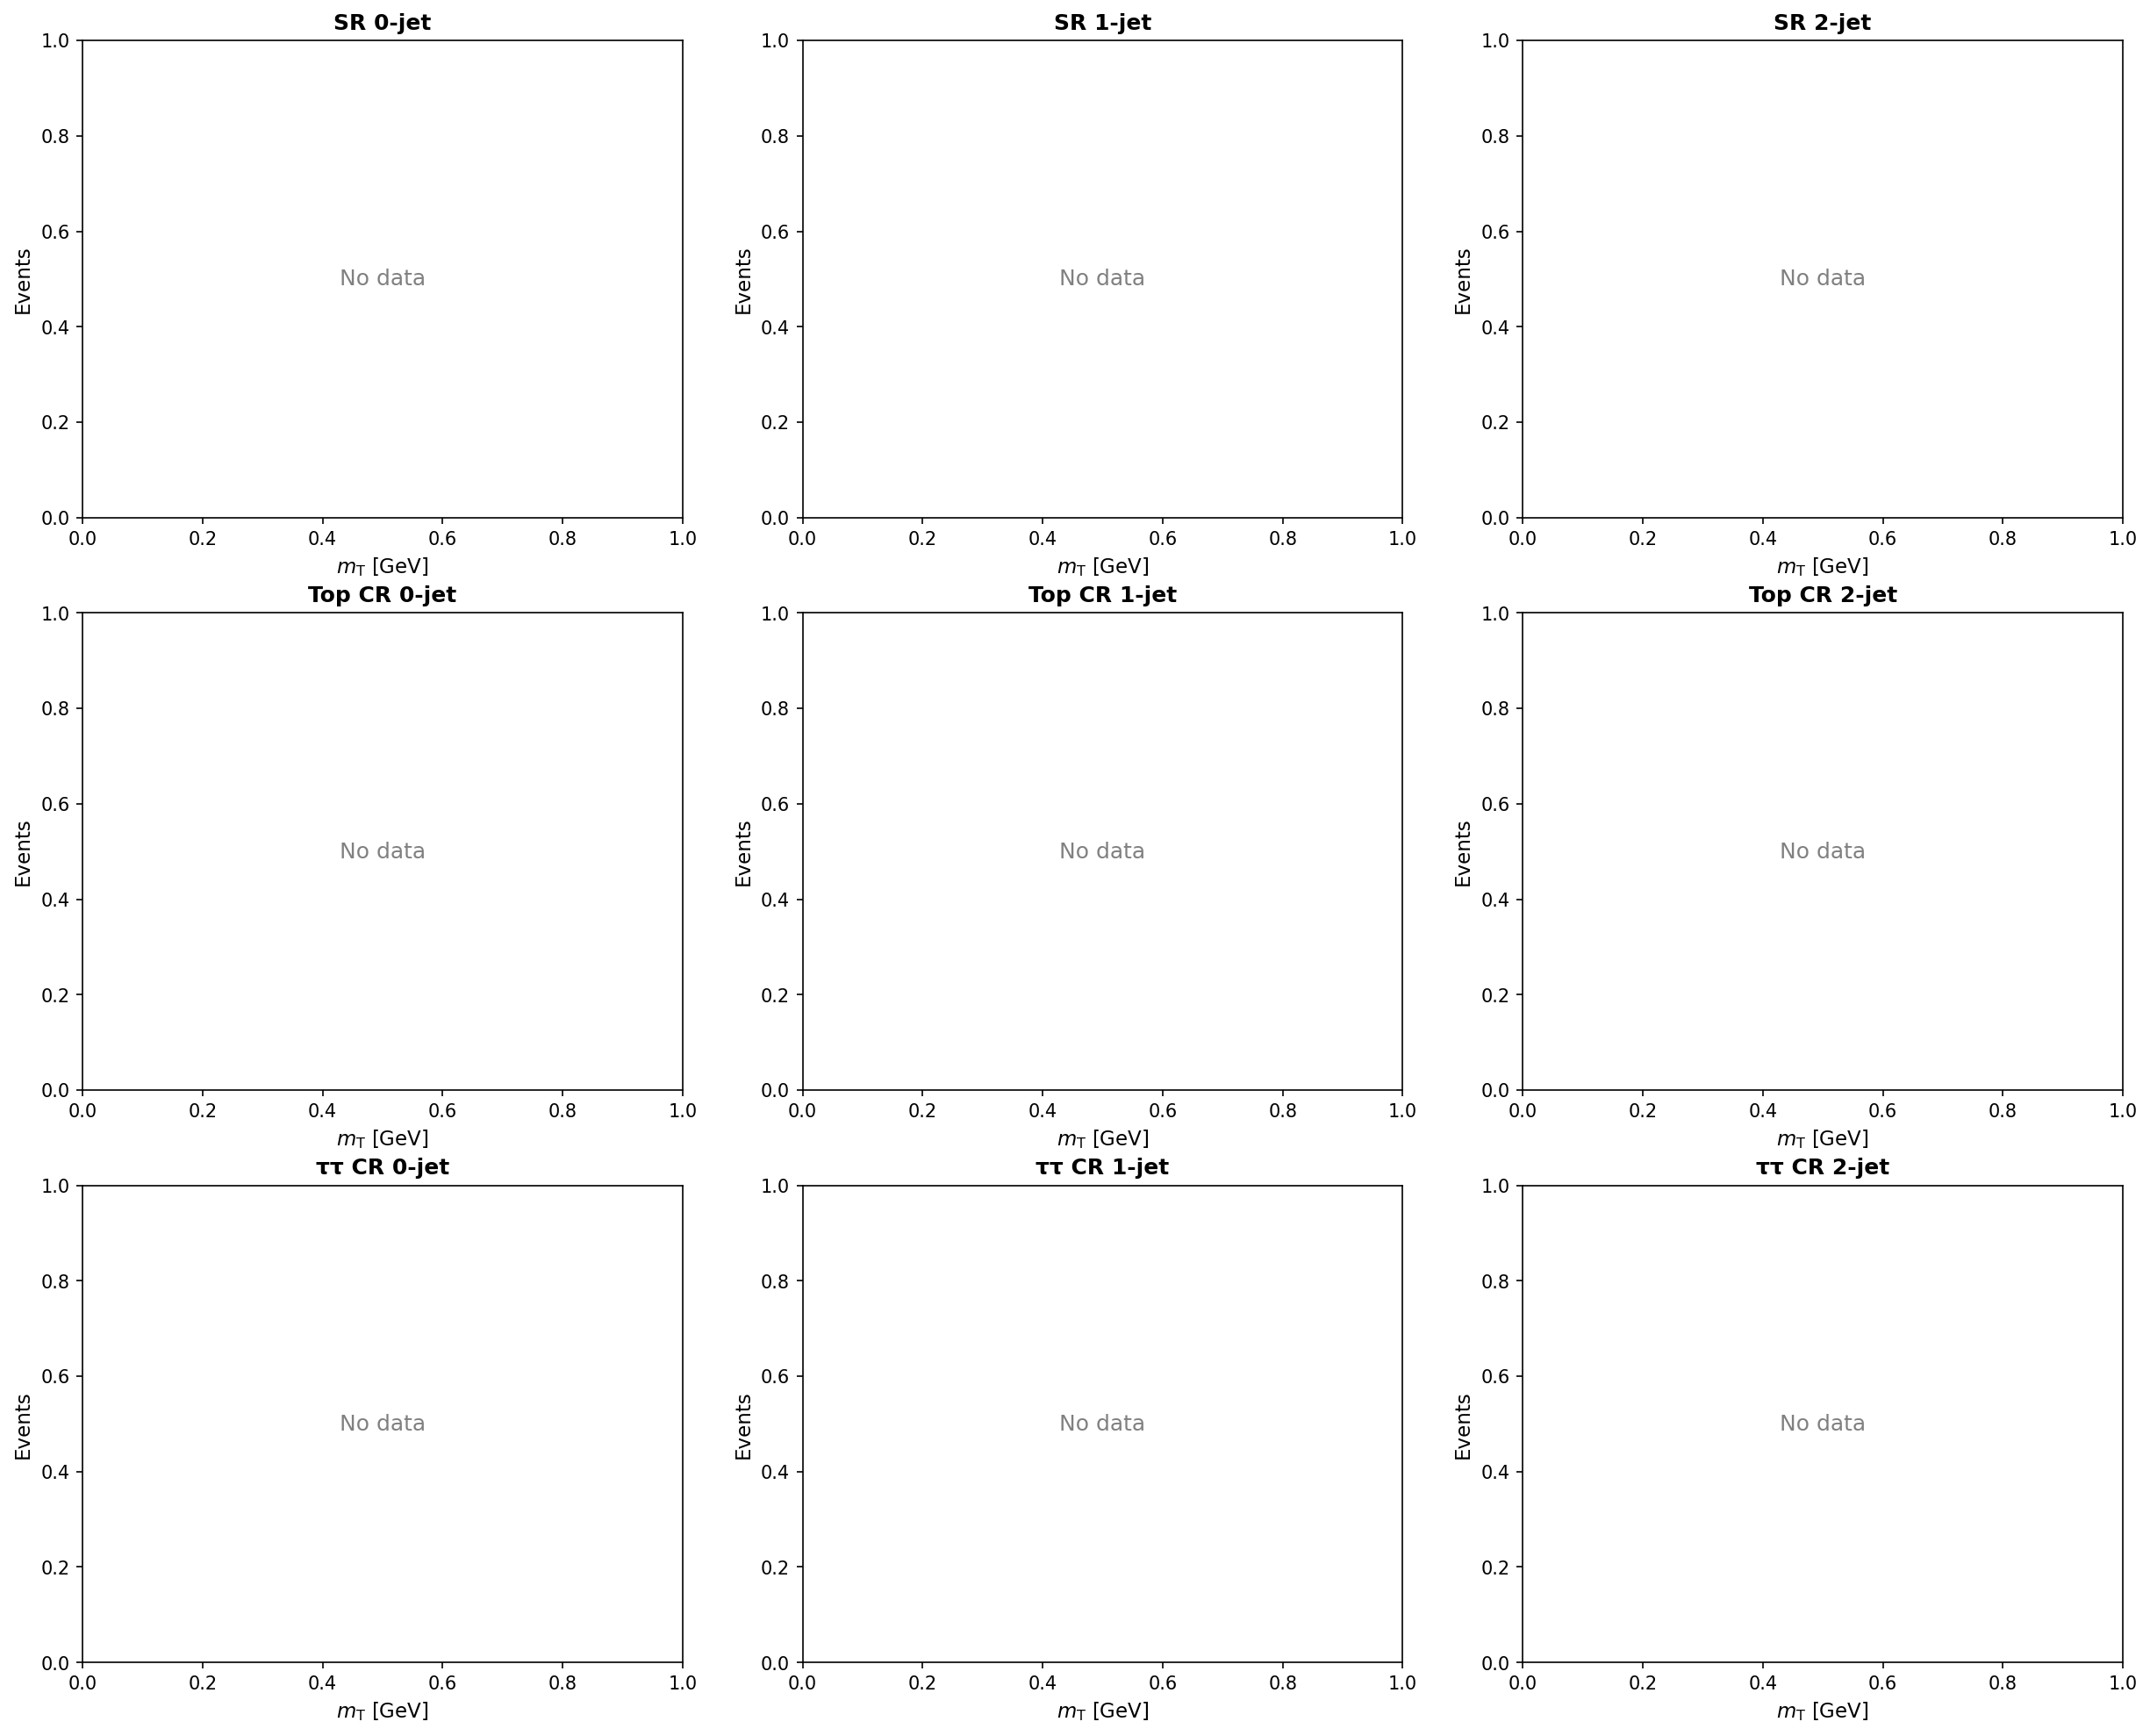

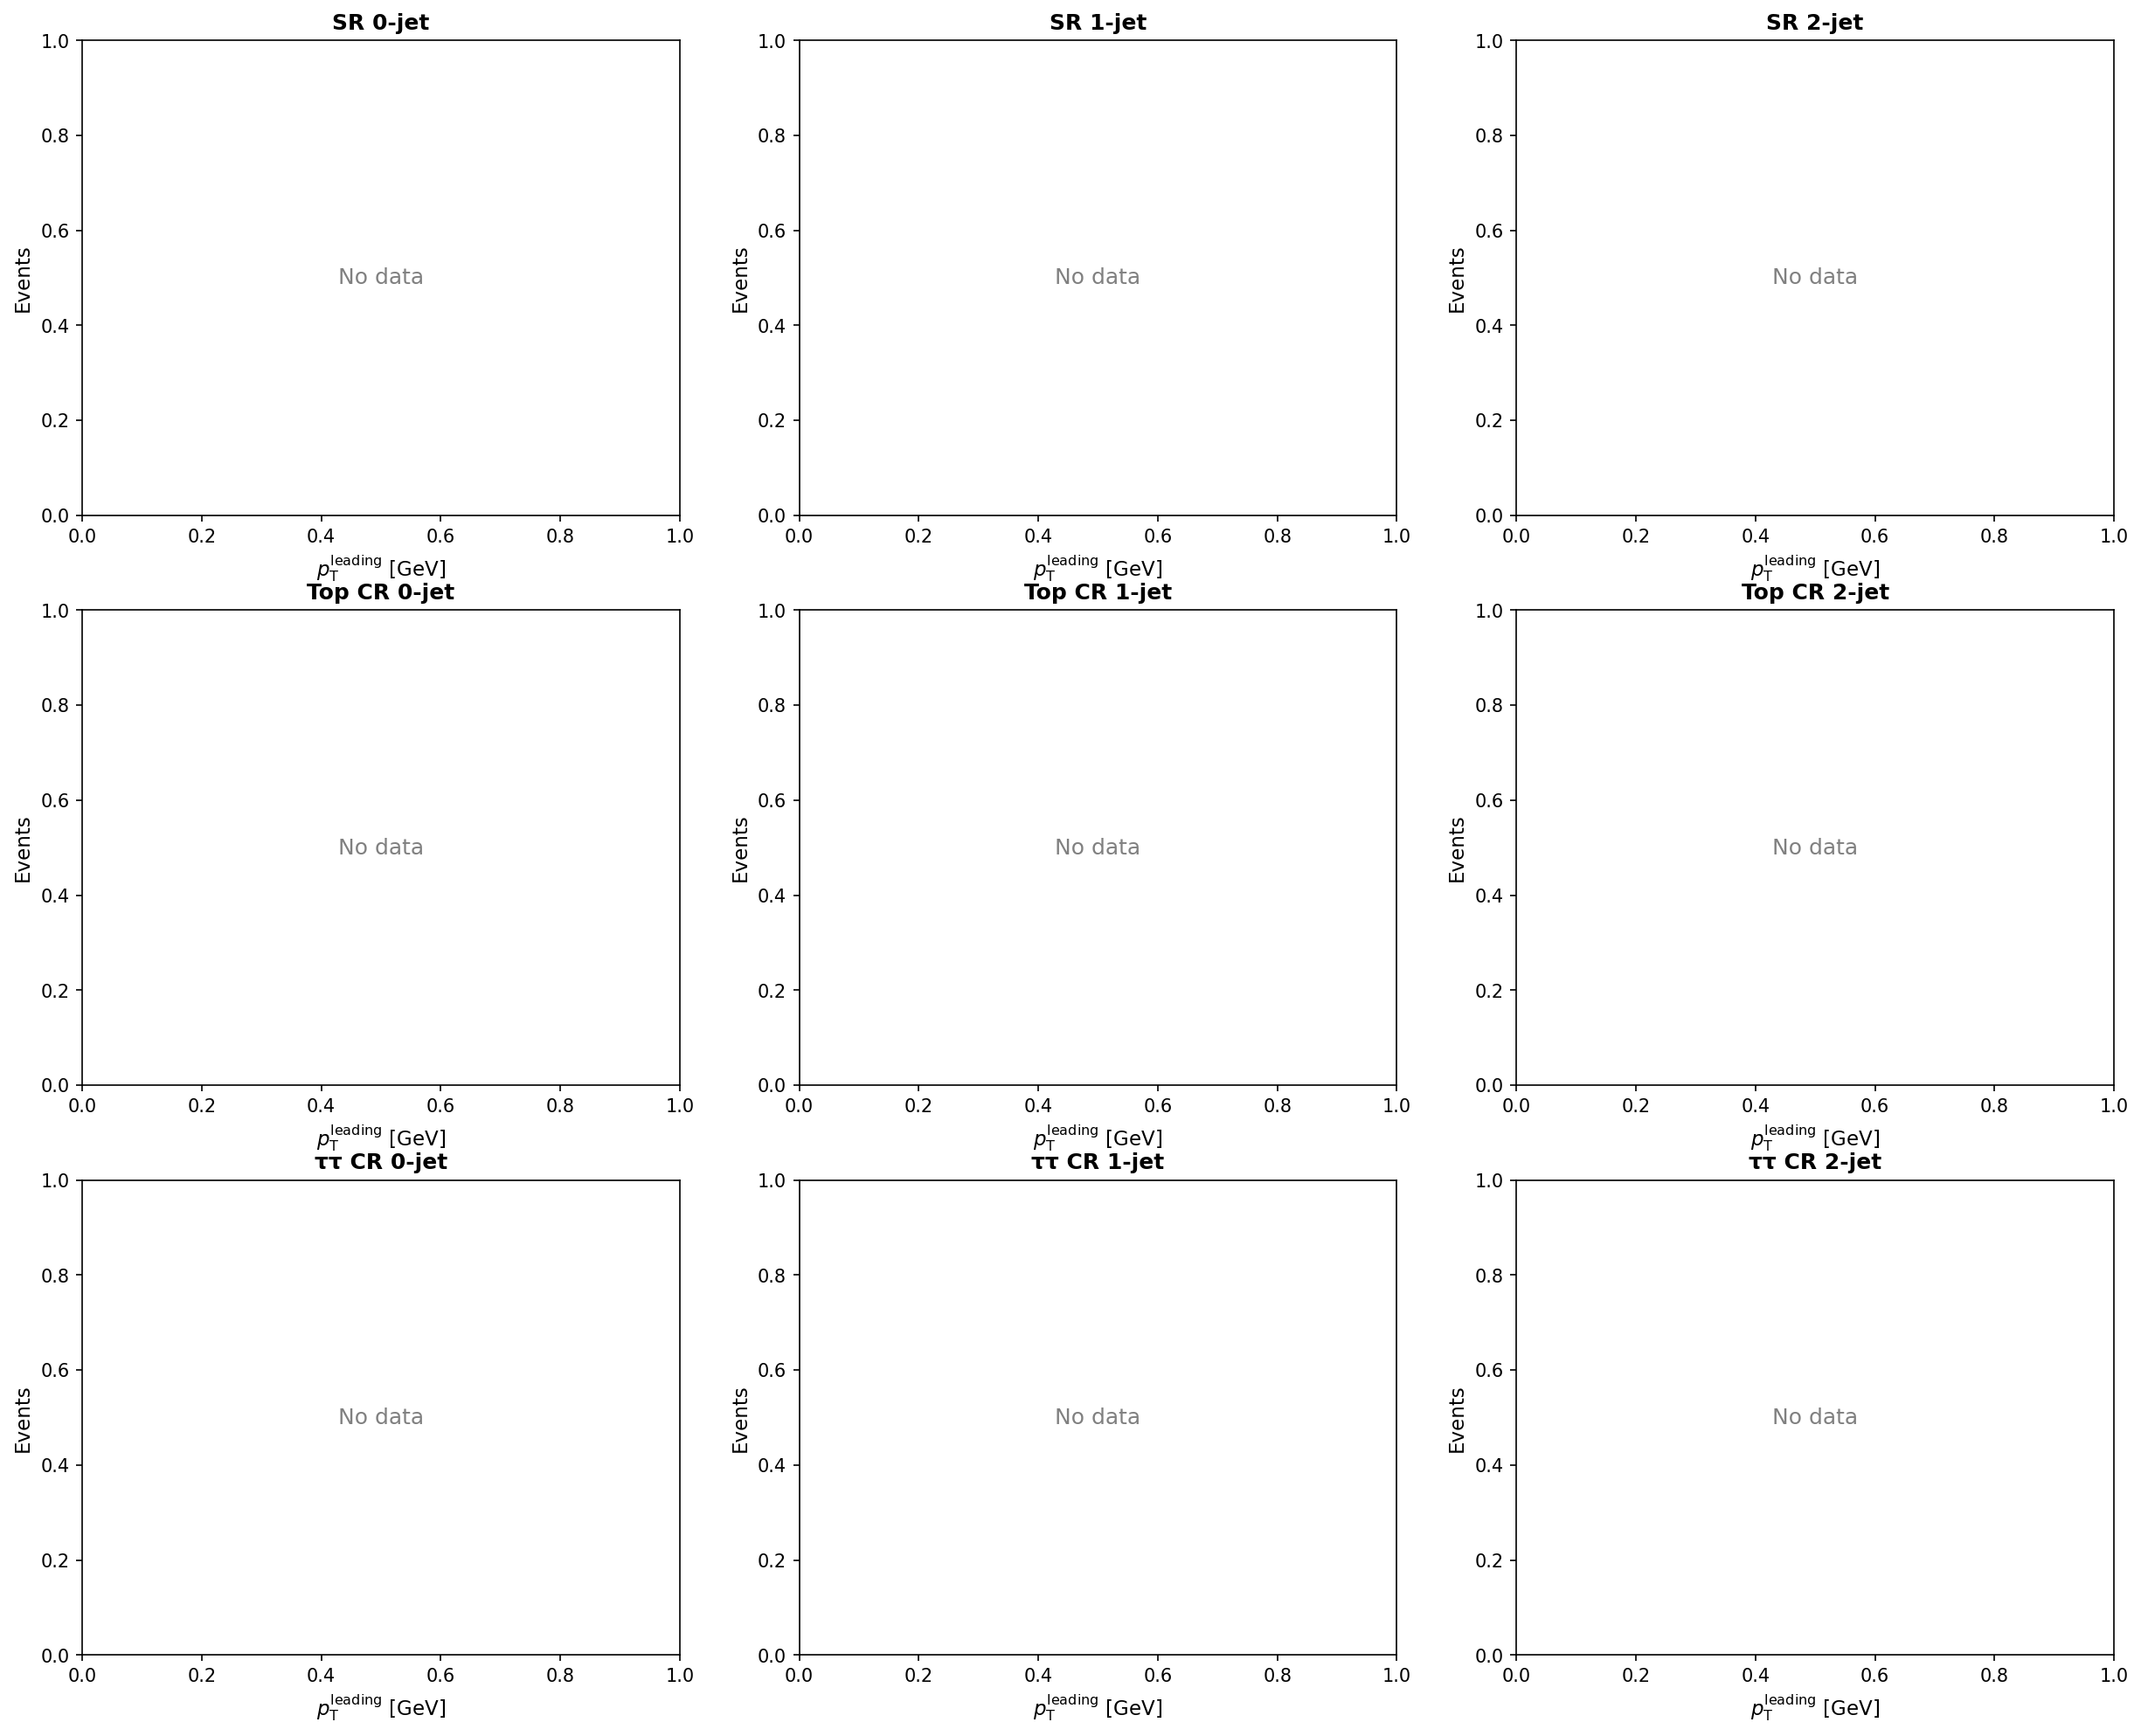

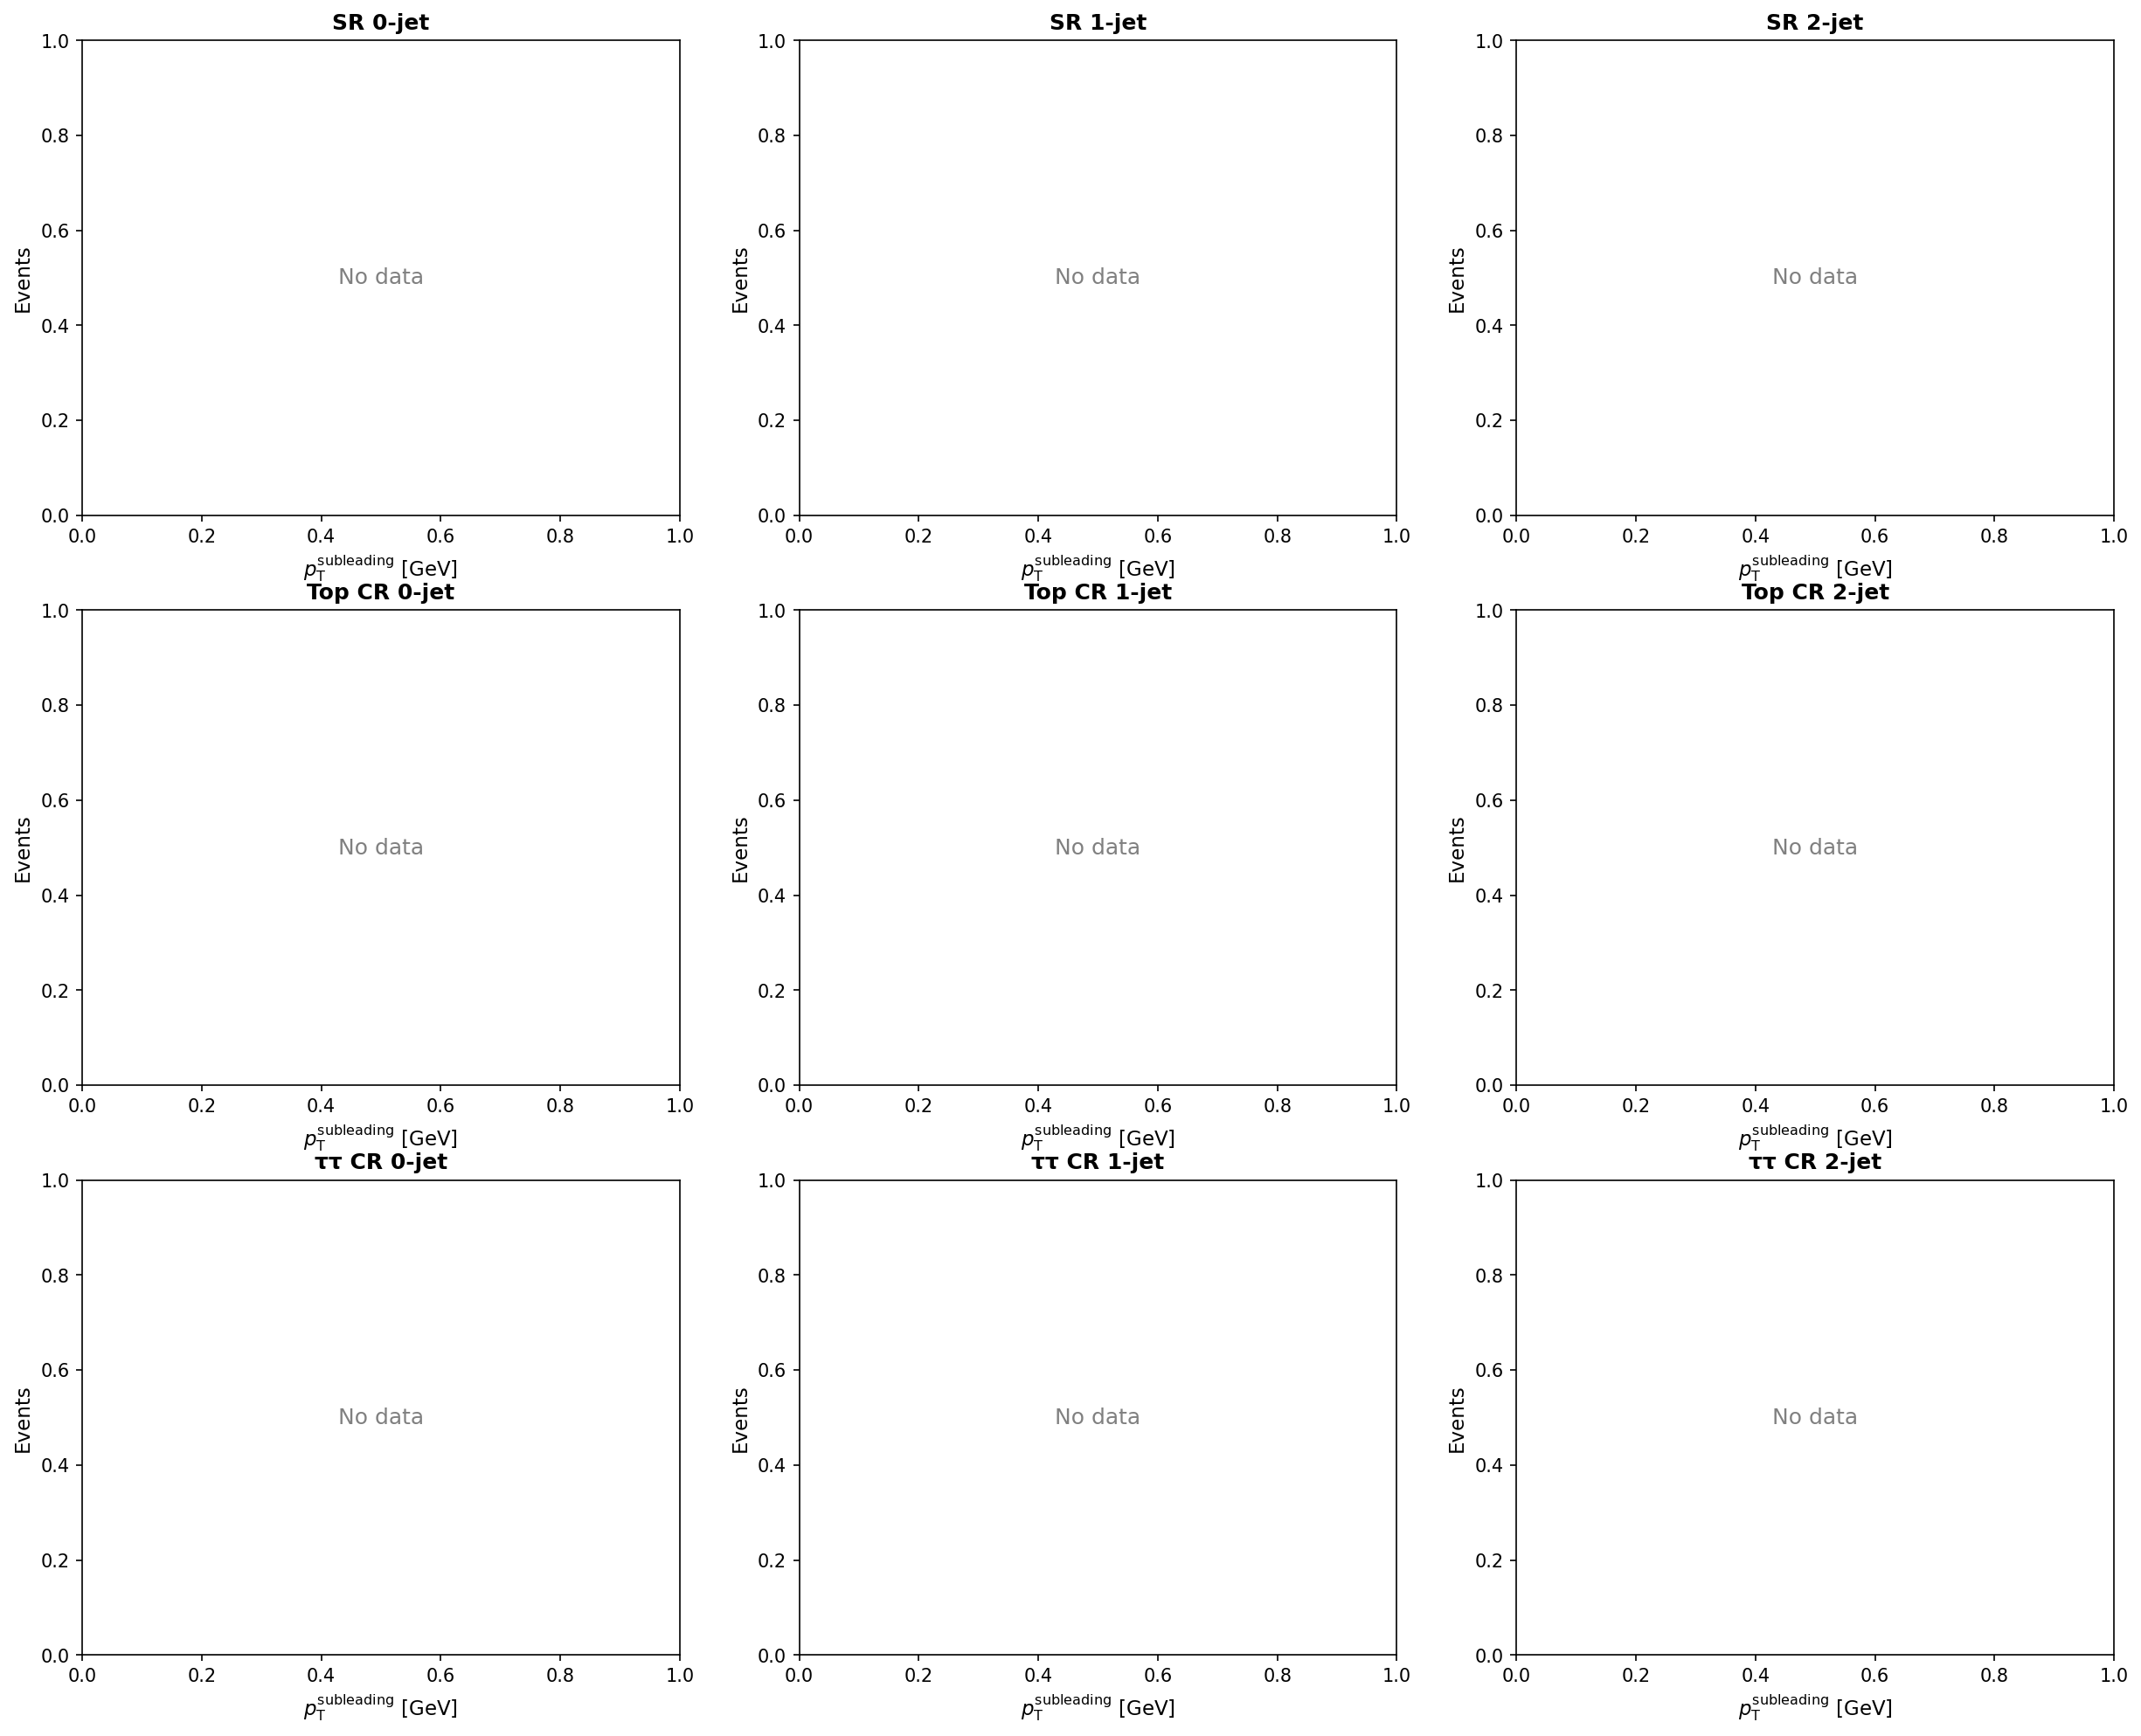

In [88]:
# =============================================================================
# SAVE AND DISPLAY PLOTS
# =============================================================================

def plot_all_distributions(hist_data_all, output_dir='plots', display_plots=True):
    """
    Generate all distribution plots and save them.
    
    Parameters:
    -----------
    hist_data_all : dict
        Histogram data
    output_dir : str
        Directory to save plots
    display_plots : bool
        If True, display plots in notebook after saving
    """
    
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary of all plotting functions
    plot_functions = {
        'mass': plot_mass_distribution,
        'met': plot_met_distribution,
        'ptll': plot_ptll_distribution,
        'dphi': plot_dphi_distribution,
        'mt': plot_mt_distribution,
        'pt_leading_lep': plot_pt_leading_lepton,
        'pt_subleading_lep': plot_pt_subleading_lepton,
    }
    
    print("\n" + "="*80)
    print("GENERATING ALL DISTRIBUTION PLOTS")
    print("="*80)
    
    for var_name, plot_func in plot_functions.items():
        print(f"\n Plotting {var_name}...")
        
        try:
            # Generate plot
            fig = plot_func(hist_data_all)
            
            # Save figure
            output_path = os.path.join(output_dir, f'{var_name}_distribution.png')
            fig.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"    Saved: {output_path}")
            
            # Display if requested
            if display_plots:
                plt.show()
            
            # Close figure to free memory
            plt.close(fig)
            
        except Exception as e:
            print(f"    Error plotting {var_name}: {e}")
    
    print("\n" + "="*80)
    print(" ALL PLOTS GENERATED SUCCESSFULLY")
    print(f" Plots saved to: {output_dir}")
    print("="*80 + "\n")


# Usage
if __name__ == "__main__" or "hist_data_final" in dir():
    
    output_dir = '/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/distributions'
    
    # Generate, save, AND display
    plot_all_distributions(hist_data_final, output_dir=output_dir, display_plots=True)
    
    # Or just save without displaying
    # plot_all_distributions(hist_data_final, output_dir=output_dir, display_plots=False)